Vortex dynamics in coherently coupled Bose-Einstein condensates
===============================================================
This notebook is the computational appendix of [arXiv:1609.03966](http://arxiv.org/abs/1609.03966). We spell out in detail how to obtain the numerical results in the manuscript. We rely on [Trotter-Suzuki-MPI](https://trotter-suzuki-mpi.github.io/), a massively parallel solver for the Gross--Pitaevskii equation, and its [Python wrapper](http://trotter-suzuki-mpi.readthedocs.org/). The calculations use only a single computer, but it can take many hours to finish them. For the time-consuming parts, the execution time is mentioned running on an i7-4790 CPU with four physical (eight logical) cores. The total time to run the notebook is about seven hours.

Table of Contents
-----------------
[Preliminaries](#preliminaries)

[Precession of two vortices in a two-component BEC](#precessionoftwo)

[Transfer of a single vortex between a two-component BEC](#transfersingle)

[Oscillations of the relative density](#oscillations)

Important
-------------
Throughout the notebook we use a negative value for the Rabi coupling constant. This is needed since the Hamiltonian of the Rabi coupling implemented in trottersuzuki and the Hamiltonian used in the manuscript differ from a sign.

Preliminaries
-------------
First we import the necessary modules and ensure that we get identical behaviour in Python 2 and 3.

In [1]:
from __future__ import print_function, division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib.collections import LineCollection
import numpy as np
import pandas
from scipy.interpolate import spline, InterpolatedUnivariateSpline
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import time
import trottersuzuki as ts
import seaborn as sns  # prettifies plots
sns.set_context("notebook", font_scale=2., rc={"lines.linewidth": 3})
%matplotlib inline

Two vortices in a two-component BEC
-------------------------------------------------
The following function takes two parameters $l_{\Omega}/r_{12}$ and $R$, and returns $\Omega_{rot}/\Omega$. The system is inizialized with two co-rotating vortices located symmetrically across the center of the container. The vortices, and the corresponding domain wall in the relative phase between them, are obtained performing a short imaginary time evolution, which proceeds along the following steps: 
  1. We start with normalized wavefunctions which take a constant value inside the circular well, $\psi_1 = \psi_2 =\sqrt{1/\pi R^2}$, and vanish outside.
  2. We phase-imprint two co-rotating vortices, one per component.
  3. We start the imaginary time evolution, in presence of an additional pinning potential (two sharply peaked Gaussians) aimed at keeping the vortex cores stationary (else, they would approach each other during the imaginary time evolution). 

Once the gas has stabilized, we remove the pinning potential, and we let the system evolve in real time. The precession frequency $\Omega_{rot}$ is obtained by averaging typically over $\sim5$ full revolutions.

In [2]:
def two_vortices(lOmega_over_r12, radius):
    ###
    #  Definition of variables and functions for the simulation
    ###
    
    ## Fixed variables
    length = 2. * radius                           # physical lenght of the lattice's side
    initial_vortices_distance = 1.0                # physical distance between vortices cores
    n_0 = 4 / (np.pi * length**2)                  # density at the center of the circular box
    if lOmega_over_r12 >= 0.5:                     # set r_{12} / \xi
        r12_over_Xi12 = 10.
    else:
        r12_over_Xi12 = 40.
    
    ### Lattice parameters
    const = 4.                                     # Ensure that one coherence length will be equal to "const" lattice spacings
    dim = int(length * const * r12_over_Xi12) + 1  # linear dimension of the lattice
    
    ### Hamiltonian parameters
    g_a = 10. * r12_over_Xi12**2 / (2. * n_0) # intra-particle coupling (first component)
    g_b = 10. * r12_over_Xi12**2 / (2. * n_0) # intra-particle coupling (second component)
    g_ab = 0                                  # inter-particle coupling
    omega_rabi = -1. / (lOmega_over_r12**2)   # Rabi coupling (it is negative since the library use a different sign convention)
    
    ### Solver parameters
    delta_t = 2.5e-5  # time for a single step evolution
    
    # Definition of the pinning potential (only for imaginary time evolution)
    gaussian_radius = 0.5/r12_over_Xi12
    gaussian_height = 100000
    
    def external_potential_imag_a(x, y):
        if (x**2 + y**2) >= (length/2.05)**2:
            return 1e10
        elif np.sqrt((x-1/2)**2+y**2) <= gaussian_radius:
            return gaussian_height*np.exp(- ((x-1/2)**2+y**2) / gaussian_radius**2) / (np.pi * gaussian_radius**2)
        else:
            return 0.
    
    def external_potential_imag_b(x, y):
        if (x**2 + y**2) >= (length/2.05)**2:
            return 1e10
        elif np.sqrt((x+1/2)**2+y**2) <= gaussian_radius:
            return gaussian_height*np.exp(- ((x+1/2)**2+y**2) / gaussian_radius**2) / (np.pi * gaussian_radius**2)
        else:
            return 0.
    
    # Definition of the circular well external potential (only for real time evolution)
    def external_potential(x, y):
        if (x**2 + y**2) >= (length/2.1)**2:
            return 1e10
        else:
            return 0.
    
    # Normalized initial state's wave function
    def const_state(x, y):
        return 1./length
    
    # Define the vortex in component 1
    def vortex_a(x, y):
        z = (x-initial_vortices_distance/2.) + 1j*y
        angle = np.angle(z)
        return np.exp(1j * angle)
    
    # Define the vortex in component 2
    def vortex_b(x, y):
        z = (x+initial_vortices_distance/2.) + 1j*y
        angle = np.angle(z)
        return np.exp(1j * angle)

    
    ###
    #  Set up of the simulation
    ###
    
    # Set the geometry of the simulation
    grid = ts.Lattice(dim, length)
    
    # Set the Hamiltonian
    potential_a = ts.Potential(grid)  # Set the pinning potential for the first component 
    potential_a.init_potential(external_potential_imag_a)
    potential_b = ts.Potential(grid)  # Set the pinning potential for the second component
    potential_b.init_potential(external_potential_imag_b)
    hamiltonian = ts.Hamiltonian2Component(grid, potential_a, potential_b, 1., 1.,
                                           g_a, g_ab, g_b, omega_rabi)
    
    # Set the initial state
    state_a = ts.State(grid)        # Initialize the state in the first component
    state_a.init_state(const_state)
    state_b = ts.State(grid)        # Initialize the state in the second component
    state_b.init_state(const_state)
    
    # Imprint the vortices on the corresponding components
    state_a.imprint(vortex_a)
    state_b.imprint(vortex_b)
    
    # Initialize the solver
    solver = ts.Solver(grid, state_a, state_b, hamiltonian, delta_t)
    
    ###
    #  Set up imaginary time evolution
    ###
    
    # Calculate initial vortices distance
    coord_a = ts.vortex_position(grid, state_a, length*0.45)
    coord_b = ts.vortex_position(grid, state_b, length*0.45)
    vortex_distance = np.sqrt((coord_b[0]-coord_a[0])**2 + (coord_b[1]-coord_a[1])**2)
    
    # Decide how many imaginary iterations to perform
    # NB: the higher the Rabi coupling, the higher the iterations needed to form the domain wall
    iterations = 1000
    if lOmega_over_r12 < .2:
        num = 1
    elif lOmega_over_r12 < .5:
        num = 4
    elif lOmega_over_r12 < 1.:
        num = 15
    else:
        num = 24
    
    # Start imaginary time evolution
    for i in range(num):
        solver.evolve(iterations, True)         # Perform imaginary time evolution
    
    # Calculate vortices distance after imaginary time evolution
    coord_a = ts.vortex_position(grid, state_a, length*0.45)
    coord_b = ts.vortex_position(grid, state_b, length*0.45)
    vortex_distance = np.sqrt((coord_b[0]-coord_a[0])**2 + (coord_b[1]-coord_a[1])**2)

    # Check whether the vortices distance has significantly changed and if true abort
    if np.abs(vortex_distance - initial_vortices_distance) > grid.delta_x:
        return
    
    ###
    #  Set up real time evolution
    ###
    
    # Change external potential to the circular wall without the pinning potential
    potential_a.init_potential(external_potential)
    potential_b.init_potential(external_potential)
    solver.update_parameters()    
    
    # Iterations to perform to get a tot_angle
    max_it_real_time = 20
    if lOmega_over_r12 < .5:
        iterations = 30
    elif lOmega_over_r12 < 1.:
        iterations = 8000
    else:
        iterations = 16000
    
    angles_12 = []   # List of precession angles
    times = []       # List of times
    const_angle = 0. # Angle offset
    
    # Start real time evolution
    for cont in range(max_it_real_time):
        solver.evolve(iterations)
        
        # Calculate the precession angle of the vector r_12
        coord_a = ts.vortex_position(grid, state_a, length*0.45)  # Get position of the vortex in the first component
        coord_b = ts.vortex_position(grid, state_b, length*0.45)  # Get position of the vortex in the second component
        
        angles = np.angle(coord_a[0] - coord_b[0] + 1j * (coord_a[1] - coord_b[1])) # Calculate precession angle
        
        # Add an offset
        if cont > 2:
            last_angle = angles_12[len(angles_12)-2]
        else:
            last_angle = angles
        if abs(angles + const_angle - last_angle) > np.pi:
            const_angle += 2. * np.pi * np.sign(last_angle)
        
        angles_12.append(angles + const_angle)
        times.append(delta_t * iterations * (cont+1))
        
    ###
    #  Calculate precession frequency
    ###
    
    # fit angles curve
    fit_par = np.polyfit(times, angles_12, 1)  # fit_par[0] is the precession frequency  
    
    return fit_par[0] / np.abs(omega_rabi)  # return \Omega_{rot} / \Omega

It follows a function for the simulation of two counter-rotating vortices. The precession frequency and the translational velocity are calculated.

In [3]:
def two_counter_rotating_vortices(lOmega_over_r12, radius):
    ###
    #  Definition of variables and functions for the simulation
    ###
    
    ## Fixed variables
    length = 2. * radius                           # physical lenght of the lattice's side
    initial_vortices_distance = 1.0                # physical distance between vortices cores
    n_0 = 4 / (np.pi * length**2)                  # density at the center of the circular box
    if lOmega_over_r12 >= 0.3:                     # set r_{12} / \xi
        r12_over_Xi12 = 20.
    else:
        r12_over_Xi12 = 40.
    
    ### Lattice parameters
    const = 2.
    dim = int(length * const * r12_over_Xi12) + 1      # linear dimension of the lattice
    
    ### Hamiltonian parameters
    g_a = r12_over_Xi12**2 / (2. * n_0) # intra-particle coupling (firt component)
    g_b = r12_over_Xi12**2 / (2. * n_0) # intra-particle coupling (second component)
    g_ab = 0                                  # inter-particle coupling
    omega_rabi = -1. / (lOmega_over_r12**2)   # Rabi coupling (it is negative since the library use a different sign convention)
    
    ### Solver parameters
    delta_t = 2.5e-5  # time for a single step evolution
    
    # Definition of the pinning potential (only for imaginary time evolution)
    gaussian_radius = 0.5/r12_over_Xi12
    gaussian_height = 100000
    
    def external_potential_imag_a(x, y):
        if (x**2 + y**2) >= (length/2.05)**2:
            return 1e10
        elif np.sqrt((x-1/2)**2+y**2) <= gaussian_radius:
            return gaussian_height*np.exp(- ((x-1/2)**2+y**2) / gaussian_radius**2) / (np.pi * gaussian_radius**2)
        else:
            return 0.
    
    def external_potential_imag_b(x, y):
        if (x**2 + y**2) >= (length/2.05)**2:
            return 1e10
        elif np.sqrt((x+1/2)**2+y**2) <= gaussian_radius:
            return gaussian_height*np.exp(- ((x+1/2)**2+y**2) / gaussian_radius**2) / (np.pi * gaussian_radius**2)
        else:
            return 0.
    
    # Definition of the circular well external potential (only for real time evolution)
    def external_potential(x, y):
        if (x**2 + y**2) >= (length/2.05)**2:
            return 1e10
        else:
            return 0.
    
    # Normalized initial state's wave function
    def const_state(x, y):
        return 1./length
    
    # Define the vortex in component 1
    def vortex_a(x, y):
        z = (x-initial_vortices_distance/2.) + 1j*y
        angle = np.angle(z)
        return np.exp(1j * angle)
    
    # Define the vortex in component 2
    def vortex_b(x, y):
        z = (x+initial_vortices_distance/2.) + 1j*y
        angle = np.angle(z)
        return np.exp(-1j * angle)
    
    ###
    #  Set up of the simulation
    ###
    
    # Set the geometry of the simulation
    grid = ts.Lattice(dim, length)
    
    # Set the Hamiltonian
    potential_a = ts.Potential(grid)  # Set the pinning potential for the first component 
    potential_a.init_potential(external_potential_imag_a)
    potential_b = ts.Potential(grid)  # Set the pinning potential for the second component
    potential_b.init_potential(external_potential_imag_b)
    hamiltonian = ts.Hamiltonian2Component(grid, potential_a, potential_b, 1., 1.,
                                           g_a, g_ab, g_b, omega_rabi)
    
    # Set the initial state
    state_a = ts.State(grid)        # Initialize the state in the first component
    state_a.init_state(const_state)
    state_b = ts.State(grid)        # Initialize the state in the second component
    state_b.init_state(const_state)
    
    # Imprint the vortices on the corresponding components
    state_a.imprint(vortex_a)
    state_b.imprint(vortex_b)
    
    # Initialize the solver
    solver = ts.Solver(grid, state_a, state_b, hamiltonian, delta_t)
    
    ###
    #  Set up imaginary time evolution
    ###
    
    # Calculate initial vortices distance
    coord_a = ts.vortex_position(grid, state_a, length*0.45)
    coord_b = ts.vortex_position(grid, state_b, length*0.45)
    vortex_distance = np.sqrt((coord_b[0]-coord_a[0])**2 + (coord_b[1]-coord_a[1])**2)
    
    # Decide how many imaginary iterations to perform
    # NB: the higher the Rabi coupling, the higher the iterations needed to form the domain wall
    iterations = 50
    num = 20
    
    # Start imaginary time evolution
    for i in range(num):
        solver.evolve(iterations, True)         # Perform imaginary time evolution
        time = iterations * (i + 1) * delta_t
        
    # Calculate vortices distance after imaginary time evolution
    coord_a = ts.vortex_position(grid, state_a, length*0.45)
    coord_b = ts.vortex_position(grid, state_b, length*0.45)
    vortex_distance = np.sqrt((coord_b[0]-coord_a[0])**2 + (coord_b[1]-coord_a[1])**2)

    ###
    #  Set up real time evolution
    ###
    
    # Change external potential to the circular wall without the pinning potential
    potential_a.init_potential(external_potential)
    potential_b.init_potential(external_potential)
    solver.update_parameters()    
    
    # Iterations
    max_it_real_time = 14
    if lOmega_over_r12 <= .1:
        iterations = 30
    elif lOmega_over_r12 <= .2:
        iterations = 200
    elif lOmega_over_r12 <= .4:
        iterations = 500
    else:
        iterations = 1000
    
    angles_12 = []   # List of precession angles
    times = []       # List of times
    const_angle = 0. # Angle offset
    time = 0.
    position_x_a = []
    position_y_a = []
    position_x_b = []
    position_y_b = []
    
    # Start real time evolution
    for cont in range(max_it_real_time):
        solver.evolve(iterations)
        
        # Calculate the precession angle of the vector r_12
        coord_a = ts.vortex_position(grid, state_a, length*0.45)  # Get position of the vortex in the first component
        coord_b = ts.vortex_position(grid, state_b, length*0.45)  # Get position of the vortex in the second component
        position_x_a.append(coord_a[0])
        position_y_a.append(coord_a[1])
        position_x_b.append(coord_b[0])
        position_y_b.append(coord_b[1])
        
        angles = np.angle(coord_a[0] - coord_b[0] + 1j * (coord_a[1] - coord_b[1])) # Calculate precession angle
        
        # Add an offset
        if cont > 2:
            last_angle = angles_12[len(angles_12)-2]
        else:
            last_angle = angles
        if abs(angles + const_angle - last_angle) > np.pi:
            const_angle += 2. * np.pi * np.sign(last_angle)
        
        angles_12.append(angles + const_angle)
        times.append(delta_t * iterations * (cont+1))
        time = iterations * (cont + 1) * delta_t

    ###
    #  Calculate precession frequency
    ###
    
    # fit angles curve
    times = np.array(times)
    angles_12 = np.array(angles_12)
    times = times[~np.isnan(angles_12)]
    angles_12 = angles_12[~np.isnan(angles_12)]
    fit_par = np.polyfit(times[0:20], angles_12[0:20], 1)  # fit_par[0] is the precession frequency 
    
    ###
    #  Calculate translational velocity
    ###
    T = 2. * np.pi / np.fabs(omega_rabi)
    time = np.arange(1,max_it_real_time+1) * iterations * delta_t / T
    fit_par_translationalVelocity_a = np.polyfit(time, position_y_a, 1)
    fit_par_translationalVelocity_b = np.polyfit(time, position_y_b, 1)
    mean_translationalVelocity = 0.5*(fit_par_translationalVelocity_a[0]+fit_par_translationalVelocity_a[0])
    
    return fit_par[0] / np.fabs(omega_rabi), mean_translationalVelocity

Simulation for co-rotating vortices. We explore the parameter space $l_{\Omega} / r_{12} \in [0.1, 10]$ and $R = 2$. The manuscript also has results for $R=3.5, 5$, but the calculations take a long time, so here only one value is evaluated.

In [4]:
interval = np.linspace(-1, 1, 21)
parameters = [2]
# parameters = [2, 3.5, 5]
df = pandas.DataFrame(index=range(len(interval)*len(parameters)),
                      columns=["length_x", "l_omega_r12", "omega_rot/omega"], dtype=np.float64)
i = 0
time0 = time.time()
for lOmega_over_r12 in np.power(10, interval):
    for radius in parameters:
        time_i = time.time()
        df.iloc[i] = [2*radius, lOmega_over_r12, two_vortices(lOmega_over_r12, radius)]
        print("Execution time:", time.time()-time_i)
        i += 1
print("Total time:", time.time()-time0)

Execution time: 132.8362259864807
Execution time: 108.85581684112549
Execution time: 108.85344958305359
Execution time: 108.23550486564636
Execution time: 213.38786602020264
Execution time: 213.50026559829712
Execution time: 213.03282761573792
Execution time: 810.127622127533
Execution time: 814.6927373409271
Execution time: 809.4469041824341
Execution time: 1613.8447659015656
Execution time: 1684.8832886219025
Execution time: 1656.4302899837494
Execution time: 1666.0066549777985
Execution time: 1621.5207834243774
Execution time: 1638.9895038604736
Execution time: 1615.692839384079
Execution time: 1651.9157457351685
Execution time: 1625.9029002189636
Execution time: 1591.2954008579254
Execution time: 1593.9853723049164
Total time: 21493.4420940876


It follows the simulation for counter-rotating vortices. We explore the parameter space $l_{\Omega} / r_{12} \in [0.1, 0.5]$ and $R = 5$.

In [5]:
radius = 5.
LOmega_over_r12 = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
Omega_rot = []
TranslationalVelocity = []
time0 = time.time()
for lOmega_over_r12 in LOmega_over_r12:
    time_i = time.time()
    omega_rot, translationalVelocity = two_counter_rotating_vortices(lOmega_over_r12, radius)
    Omega_rot.append(omega_rot)
    TranslationalVelocity.append(translationalVelocity)
    print("Execution time:", time.time()-time_i)
    
print("Total time:", time.time()-time0)

Execution time: 553.695410013
Execution time: 324.092324972
Execution time: 336.887228966
Execution time: 600.207921028
Execution time: 403.633752823
Total time: 2218.51838279


Fig. 1a plots the precession frequency of two co-rotating vortices, one per component, along with the ones for the counter-rotating vortices. Colors indicate results obtained for different radii $R$ of the circular container. The dash-dotted line is the strong-coupling limit.The following script produces the figure:

-c:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
-c:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


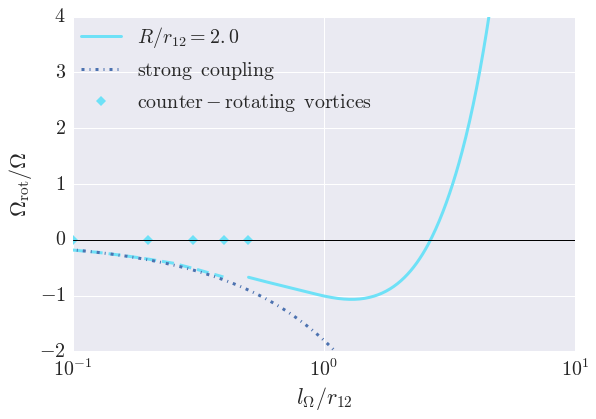

In [6]:
plt.figure(figsize=(9, 6))
mycolors = {4:"#6EE1F7", 7:"#43CA2E", 10:"#861010"}

for radius in parameters:
    length_x = int(2*radius)
    ordered_left = df[(df['length_x'] == length_x) &\
                      (df['l_omega_r12'] <= 0.50118723) &\
                      (df['l_omega_r12'] != 0.79432823) &\
                      (df['l_omega_r12'] != 0.63095734)\
                     ].sort('l_omega_r12')
    ordered_right = df[(df['length_x'] == length_x) &\
                       (df['l_omega_r12'] >= 0.50118723) &\
                       (df['l_omega_r12'] != 0.79432823) &\
                       (df['l_omega_r12'] != 0.63095734)\
                      ].sort('l_omega_r12')
    x_l = ordered_left['l_omega_r12']
    y_l = ordered_left['omega_rot/omega']
    x_r = ordered_right['l_omega_r12']
    y_r = ordered_right['omega_rot/omega']
    x_rm = x_r.as_matrix()
    y_rm = y_r.as_matrix()
    x_r2 = np.linspace(x_rm.min(), x_rm.max(), 300)
    y_r2 = spline(x_rm, y_rm, x_r2)
    plt.plot(x_l, y_l, "--", dashes = [12, 6], label="", color=mycolors[length_x])
    plt.plot(x_r2, y_r2, label='$R/r_{12}=%.1f$' % radius, color=mycolors[length_x])

# add the strong coupling limit
x = np.linspace(0, 2, 100)
y = -4*np.sqrt(2)*x/np.pi
plt.plot(x, y, '-.', label="$\mathrm{strong} \,\,\, \mathrm{coupling}$");

# add counter-rotating vortices
plt.plot(LOmega_over_r12,Omega_rot,'D', color=mycolors[4], lw=2, label="$\mathrm{counter-rotating} \,\,\, \mathrm{vortices}$");

# set labels and limits
plt.xscale('log')
plt.xlabel("$l_\Omega/r_{12}$")
plt.ylabel("$\Omega_\mathrm{rot}/\Omega$")
plt.xlim(0.1, 10)
plt.ylim(-2, 4)
plt.yticks([-2, -1, 0, 1, 2, 3, 4], ['$-2$', '$-1$', '$0$', '$1$', '$2$', '$3$', '$4$'])
plt.xticks([0.1, 1, 10], ['$10^{-1}$', '$10^{0}$', '$10^{1}$', ])
plt.axhline(0, color='black', linewidth=1)
lgd = plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.);
plt.show()

The same data are plotted with different axes, to highlight the behavior at weak-coupling. Here $\omega_{12} \equiv \hbar/M r_{12}^2$, and the dots are the result expected for a single vortex in a single component BEC inside a cylinder. This scripts generates Fig. 1b in the manuscript:

-c:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


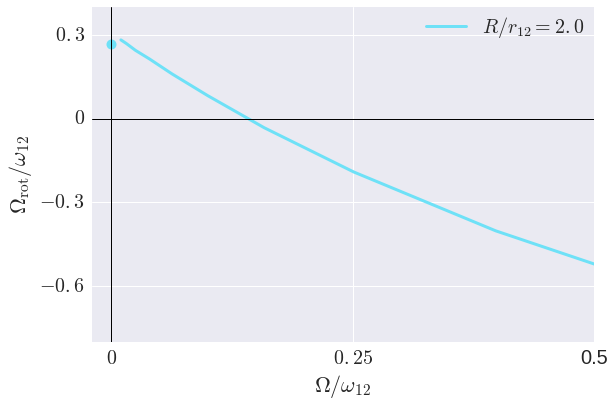

In [7]:
plt.figure(figsize=(9, 6))

for radius in parameters:
    length_x = int(2*radius)
    ordered = df[df['length_x'] == length_x].sort('l_omega_r12')
    x = 1. / (ordered['l_omega_r12'])**2
    y = x * ordered['omega_rot/omega']
    if length_x == 4:
        label='$R/r_{12}=2$'
    if length_x == 7:
        label='$R/r_{12}=3.5$'
    if length_x == 10:
        label='$R/r_{12}=5$'

    plt.plot(x, y, label='$R/r_{12}=%.1f$' % radius, color=mycolors[length_x])
    # positions to inter/extrapolate
    xi = np.linspace(0, .25, 10)
    # spline order: 1 linear, 2 quadratic, 3 cubic ... 
    order = 1
    # do inter/extrapolation   (the data must be monotonously increasing)
    data_x = (np.array(x)[::-1])[:7]
    data_y = (np.array(y)[::-1])[:7]
    s = InterpolatedUnivariateSpline(data_x, data_y, k=order)
    yi = s(xi)
    # add the result for a single off-centered vortex in a cylindrical container; see Pethick&Smith, Chap.(9.4), Eq.(9.46)
    b = 0.5;
    plt.plot([0], [1 / (((length_x/2)**2 - b**2))], 'o', label="", markersize=10, color=mycolors[length_x])

# set labels and limits
plt.xlabel("$\Omega/\omega_{12}$")
plt.ylabel("$\Omega_\mathrm{rot}/\omega_{12}$")
plt.xlim(-0.02, .5)
plt.xticks([0., .25, 0.5], ['$0$', '$0.25$', '0.5'])
plt.ylim(-.8, .4)
plt.yticks([-.6, -.3, 0, .3], ['$-0.6$', '$-0.3$', '$0$', '$0.3$']);
plt.axhline(0, color='black', linewidth=1);
plt.axvline(0, color='black', linewidth=1);
lgd = plt.legend(bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0.);
plt.show()

The translational velocity of two counter-rotating vortices is shown and compared with the theoretical result for strong coupling. See Fig. 2 in the manuscript.

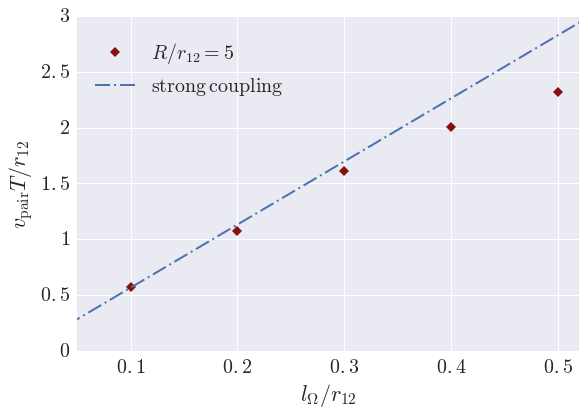

In [8]:
plt.figure(figsize=(9,6));
plt.plot(LOmega_over_r12, np.fabs(TranslationalVelocity),'D',label='$R/r_{12}=5$', color="#861010")

# theoretical curve
y = 4.*np.sqrt(2)*np.array([0,1])
plt.plot(np.array([0,1]),y,'-', dashes=[15, 4, 2, 4], lw=2, label="$\mathrm{strong} \, \mathrm{coupling}$")

# set labels and limits
plt.xlabel("$l_{\Omega}/r_{12}$")
plt.ylabel("$v_{\mathrm{pair}} T / r_{12}$")
plt.xlim(0.05,.52)
plt.ylim(0,3)
plt.yticks([0,.5,1,1.5,2,2.5,3], ['$0$','$0.5$','$1$','$1.5$','$2$','$2.5$','$3$'])
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5],['$0.1$', '$0.2$', '$0.3$','$0.4$','$0.5$'])
plt.axhline(0, color='black',linewidth=1);
plt.axvline(0, color='black',linewidth=1);
lgd = plt.legend(bbox_to_anchor=(0.02, 0.95), loc=2, borderaxespad=0.);
plt.show()
sns.set_style("white")  # set white style for the following plots

<a id='transfersingle'></a>

Transfer of a single vortex between a two-component BEC
-------------------------------------------------------
We consider a two-component BEC with equal populations ($N_1 = N_2 = 1$), in a harmonic trap of frequency $\omega$ to illustrate the coherent oscillations of vorticity induced by the Rabi coupling $\Omega$. First we define some helper functions to compute the theoretical trajectory of the vortex:

In [9]:
def dynamic_equations(y, t, Omega, kappa, R, xi):
    u, phi = y
    c = 4./3. - 128./(45.*np.pi)
    uDot = -.25*Omega*(4./3.-c*u**2) * np.sin(phi-kappa*t) / (1.-u**2)
    phiDot = (1./(R**2 * (1.-u**2))*(np.log(R/xi) + .5*np.log(1-u**2) - .5)\
             - .25*Omega /(u*(1-u**2)) * (4./3. - 3.*c*u**2)* np.cos(phi-kappa*t))
    return [uDot, phiDot]

def dynamic_equations_ret(y, t, Omega, kappa, R, xi):
    u, phi = y
    c = 4./3. - 128./(45.*np.pi)
    uDot = .25*Omega*(4./3.-c*u**2) * np.sin(phi+kappa*t) / (1.-u**2)
    phiDot = -(1./(R**2 * (1.-u**2))*(np.log(R/xi) + .5*np.log(1-u**2) - .5)\
             - .25*Omega /(u*(1-u**2)) * (4./3. - 3.*c*u**2)* np.cos(phi+kappa*t))
    return [uDot, phiDot]

def get_theoretical_trajectory(cycle1, time1, cycle2, time2, Rabi_period, Omega_Rabi, kappa, TF_radius, xi_A):
    u = np.array([])
    phi = np.array([])
    # first component
    if cycle1 < 1.:
        y0 = [0.0001, 0.]                           # initial conditions
        time_series = np.arange(0., Rabi_period/2., 0.01)           # time of evolution
        # integrate dynamic equations
        r = odeint(dynamic_equations, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
        time1_series = time_series
    if cycle1 >= 1:
        y0 = [0.0001, 0.]                                     # initial conditions
        time_series = np.arange(0., .4*Rabi_period, 0.01) - time1        # time of evolution
        # integrate dynamic equations
        r = odeint(dynamic_equations_ret, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
        u = r[:,0]
        phi = r[:,1]
        y0 = [0.0001, 0.]                                    # initial conditions
        time_series = np.arange(0., .4*Rabi_period, 0.01) + time1        # time of evolution
        # integrate dynamic equations
        r = odeint(dynamic_equations, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
        time1_series = np.concatenate((time_series - 0.4*Rabi_period, time_series), axis=0)
    u = np.concatenate((u[::-1], r[:,0]))
    phi = np.concatenate((phi[::-1], r[:,1]))
    vTraj_x1 = []
    vTraj_y1 = []
    for idx in range(len(u)):
        vTraj_x1.append(u[idx] * np.cos(phi[idx]))
        vTraj_y1.append(u[idx] * np.sin(phi[idx]))
    
    # second component
    y0 = [0.0001, 0]                                     # initial conditions
    time_series = np.arange(0., .4*Rabi_period, 0.01) - time2        # time of evolution
    # integrate dynamic equations
    r = odeint(dynamic_equations_ret, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
    u = r[:,0]
    phi = r[:,1]
    y0 = [0.0001, 0]                                    # initial conditions
    time_series = np.arange(0., .4*Rabi_period, 0.01) + time2        # time of evolution
    # integrate dynamic equations
    r = odeint(dynamic_equations, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
    time2_series = np.concatenate((time_series - 0.4*Rabi_period, time_series), axis=0)
    
    u = np.concatenate((u[::-1], r[:,0]))
    phi = np.concatenate((phi[::-1], r[:,1]))
    vTraj_x2 = []
    vTraj_y2 = []
    for idx in range(len(u)):
        vTraj_x2.append(u[idx] * np.cos(phi[idx]))
        vTraj_y2.append(u[idx] * np.sin(phi[idx]))

    return np.array(vTraj_x1), np.array(vTraj_y1), np.array(vTraj_x2), np.array(vTraj_y2), time1_series, time2_series


We prepare the system by phase-imprinting a single vortex with positive circulation in the center of the first component, and we find the corresponding ground state by performing a short evolution in imaginary time in absence of Rabi coupling, which allows the formation of a vortex core with the suitable profile at the center of the first component. After equilibration, we switch on the Rabi coupling, and let the system evolve in real time for a variable time $t>0$. The simulation is performed by the following function:

In [10]:
def single_vortex(dim, length, Rabi_period, coupling, Rabi_periods_to_be_simulated, gAB_over_g, 
                  densities1, densities2, phases1, phases2, coord1x, coord1y, coord2x, coord2y):
    
    TF_radius = (4*coupling/np.pi)**0.25
    grid = ts.Lattice(dim, length)
    
    ## Define the Hamiltonian
    potential = ts.HarmonicPotential(grid, 1., 1.)
    
    g1, g2 = coupling, coupling
    g12 = gAB_over_g * coupling
    omega = 0
    hamiltonian = ts.Hamiltonian2Component(grid, potential, potential, 1., 1., g1, g12, g2, omega)
    
    ## Define the initial state
    width = max(TF_radius, 1)
    w = 0.5 / width**2
    state1, state2 = ts.GaussianState(grid, w), ts.GaussianState(grid, w)
    
    ## Imprint vortex phase
    def vortex_phase(x, y):
        return np.exp(1j * np.angle(x + 1j*y))
    
    state1.imprint(vortex_phase)
    
    ## Initialize the solver
    frames_per_Rabi_period = 30
    real_iterations = 700  # number of iterations performed by each instance of ts
    deltaT = Rabi_period/(real_iterations * frames_per_Rabi_period)
    
    solver = ts.Solver(grid, state1, state2, hamiltonian, deltaT)
    
    #################################################################
    ## IMAGINARY EVOLUTION
    iterations = 2000
    NumEvo = 4
    for i in range(0, NumEvo):
        solver.evolve(iterations, True)
    
    #################################################################
    ## REAL-TIME EVOLUTION
    omega = -2*np.pi / Rabi_period
    hamiltonian.omega_r = omega  # Switch on the Rabi coupling
    solver.update_parameters()
    
    iterations = real_iterations
    NumEvo = int(frames_per_Rabi_period * Rabi_periods_to_be_simulated)
    
    coord1 = ts.vortex_position(grid, state1, width).reshape((2, 1))
    coord2 = ts.vortex_position(grid, state2, width).reshape((2, 1))
    time_coord = np.array([0.])
    
    ### coherence length of BEC_A
    xi_B = 1./np.sqrt(2 * g2 * state2.get_particle_density().max()/(grid.delta_x**2))
    xi_A = xi_B
    kappa = .485
    
    ## Calculate theoretical trajectories
    cycle1 = 0.
    time1 = 0.
    cycle2 = 0.
    time2 = .5 * Rabi_period
    vTraj_x1, vTraj_y1, vTraj_x2, vTraj_y2,\
              time1_s, time2_s = get_theoretical_trajectory(cycle1, time1, cycle2, time2, Rabi_period,
                                                            np.abs(omega), kappa, TF_radius, xi_A)
    
    ## Collects all theoretical trajectories
    vTrajTot_x1 = np.array([])
    vTrajTot_y1 = np.array([])
    vTrajTot_x2 = np.array([])
    vTrajTot_y2 = np.array([])
    time1Tot_s = np.array([])
    time2Tot_s = np.array([])
    
    vTrajTot_x1 = np.concatenate((vTrajTot_x1, vTraj_x1), axis=0)
    vTrajTot_y1 = np.concatenate((vTrajTot_y1, vTraj_y1), axis=0)
    vTrajTot_x2 = np.concatenate((vTrajTot_x2, vTraj_x2), axis=0)
    vTrajTot_y2 = np.concatenate((vTrajTot_y2, vTraj_y2), axis=0)
    time1Tot_s = np.concatenate((time1Tot_s, time1_s), axis=0)
    time2Tot_s = np.concatenate((time2Tot_s, time2_s), axis=0)
    
    ## Collects particle densities and phases
    densities1.append(state1.get_particle_density())
    densities2.append(state2.get_particle_density())
    phases1.append(state1.get_phase())
    phases2.append(state2.get_phase())
    
    ## Collects simulated trajectories
    coord1x.append(coord1[0])
    coord1y.append(coord1[1])
    coord2x.append(coord2[0])
    coord2y.append(coord2[1])
    
    for i in range(0, NumEvo):
        solver.evolve(iterations)
        if (i+1 == frames_per_Rabi_period//4 or i+1 == frames_per_Rabi_period//2 or\
            i+1 == 3*frames_per_Rabi_period//4 or i+1 == frames_per_Rabi_period):
            densities1.append(state1.get_particle_density())
            densities2.append(state2.get_particle_density())
            phases1.append(state1.get_phase())
            phases2.append(state2.get_phase())
            coord1x.append(coord1[0])
            coord1y.append(coord1[1])
            coord2x.append(coord2[0])
            coord2y.append(coord2[1])
        
        _coord1 = ts.vortex_position(grid, state1, width).reshape((2, 1))
        _coord2 = ts.vortex_position(grid, state2, width).reshape((2, 1))
        coord1 = np.concatenate((coord1, _coord1.reshape((2, 1))), axis=1)
        coord2 = np.concatenate((coord2, _coord2.reshape((2, 1))), axis=1)
        time = deltaT*(i+1)*iterations
        time_coord = np.concatenate((time_coord, np.array([time])), axis=0)
        
        if ((not np.isnan(coord1[0][len(coord1[0])-1])) and np.isnan(coord1[0][len(coord1[0])-2])) or\
        ((not np.isnan(coord2[0][len(coord2[0])-1])) and np.isnan(coord2[0][len(coord2[0])-2])):
            cycle1 = (time + .5*Rabi_period) // Rabi_period
            time1 = cycle1 * Rabi_period
            cycle2 = time // Rabi_period
            time2 = (cycle2 + .5) * Rabi_period
            vTraj_x1, vTraj_y1, vTraj_x2, vTraj_y2,\
                     time1_s, time2_s = get_theoretical_trajectory(cycle1, time1, cycle2, time2, Rabi_period,
                                                                   np.abs(omega), kappa, TF_radius, xi_A)
            vTrajTot_x1 = np.concatenate((vTrajTot_x1, vTraj_x1), axis=0)
            vTrajTot_y1 = np.concatenate((vTrajTot_y1, vTraj_y1), axis=0)
            vTrajTot_x2 = np.concatenate((vTrajTot_x2, vTraj_x2), axis=0)
            vTrajTot_y2 = np.concatenate((vTrajTot_y2, vTraj_y2), axis=0)
            time1Tot_s = np.concatenate((time1Tot_s, time1_s), axis=0)
            time2Tot_s = np.concatenate((time2Tot_s, time2_s), axis=0)
    
    return coord1, coord2, time_coord, vTrajTot_x1, vTrajTot_y1, vTrajTot_x2, vTrajTot_y2, time1Tot_s, time2Tot_s    

Fig. 3 plots the contours of equal dimensionless energy $\tilde E$, for $N_1 = N_2$, $\bar\phi=0$, and $R/\xi = 5$. From left to right, $M\Omega R^2/\hbar = 0,1,10$. The figure is generated by the following code:

/usr/lib/python3/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


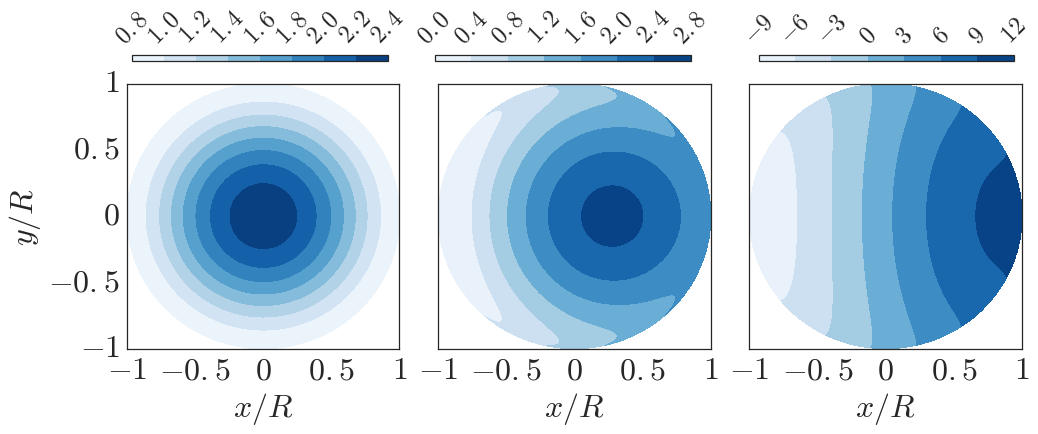

In [11]:
fig = plt.figure(figsize=(14.5, 5.9))
fontsize = 32

TF_radius = 2.24638933492  # T-F radius for g=20
xi_A = 0.423384837924      # and coherence length 

for indx in [0, 1, 2]:
    plt.subplot(1, 3, indx+1)
    if indx == 0:
        Omega_Rabi = 0.
    elif indx == 1:
        Omega_Rabi = 1./TF_radius**2
    else:
        Omega_Rabi = 10./TF_radius**2

    # vectors containing the physical coordinates
    points = 1000
    y_vec = np.linspace(-TF_radius, TF_radius, points, endpoint=False)
    x_vec =np.linspace(-TF_radius, TF_radius, points, endpoint=False)

    ## Compute vortex energy for all the position in the mesh
    X, Y = np.meshgrid(x_vec, y_vec)
    U = np.sqrt(X**2 + Y**2)/TF_radius
    N_A, N_B = 1, 1
    c = 4./3 - 128./(45*np.pi)
    Z_A = (1-U**2) * (2 * np.log(TF_radius/xi_A) + np.log(1-U**2)) + 2*U**2 - 1\
        +  Omega_Rabi * TF_radius**2 * np.sqrt(N_B/N_A) * np.absolute(4*U/3 - c*U**3) * np.cos(np.angle(X+1.0j*Y))


    #################################################################
    ## Make plot

    # set ticks and labels
    ticks_1, label_ticks_1 = [0., points/4., points/2., points*3/4., points],\
                             ['$'+str(-1)+'$', '$'+str(-0.5)+'$', '$0$', '$'+str(0.5)+'$', '$'+str(1)+'$']    
    ticks_2, label_ticks_2 = [0., points/4., points/2., points*3/4., points],\
                             ['', '', '', '', '']    
    if indx == 0:
        plt.yticks(ticks_1, label_ticks_1, fontsize=fontsize)
        plt.ylabel('$y/R$', fontsize=fontsize)
    else:
        plt.yticks(ticks_2, label_ticks_2, fontsize=fontsize)
    plt.xticks(ticks_1, label_ticks_1, fontsize=fontsize)
    plt.xlabel('$x/R$', fontsize=fontsize)

    # set levels and position of the colorbars
    if indx == 0:
        levels = np.linspace(0.8, 2.6, 9, endpoint=False)
        cbarpos = [0.1, 0.4, 0.5, 0.015]
        labelcbar = '0'
    elif indx == 1:
        levels = np.linspace(0., 3.2, 8, endpoint=False)
        cbarpos = [0.5, 0.5, 0.69, 0.015]
        labelcbar = '1'
    else:
        levels = np.linspace(-9, 15, 8, endpoint=False)
        cbarpos = [0.1, 1.1, 0.3, 0.015]
        labelcbar = '2'
    barticks = []
    for jj in range(len(levels)):
        if indx != 2:
            barticks.append('$'+str(levels[jj])+'$')
        else:
            barticks.append('$%4.0f$' % (levels[jj]))

    cont_ = plt.contourf(Z_A, levels, cmap='Blues')    # plot the energy levels

    # set ticks of the colorbars
    if indx == 0:
        cbarpos = [0.13, .89, 0.245, 0.015]
        labelcbar = '0'
        cbaxes0 = fig.add_axes(cbarpos, label=labelcbar)
        cbar = plt.colorbar(cont_, cax = cbaxes0, orientation='horizontal')
        cbar.ax.tick_params(labelsize=fontsize-8)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.set_xticklabels(barticks, rotation=45)
    elif indx == 1:
        cbarpos = [0.42, 0.89, 0.245, 0.015]
        labelcbar = '1'
        cbaxes1 = fig.add_axes(cbarpos, label=labelcbar)
        cbar = plt.colorbar(cont_, cax = cbaxes1, orientation='horizontal')
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=fontsize-8)
        cbar.ax.set_xticklabels(barticks, rotation=45)
    else:
        cbarpos = [0.73, .89, 0.245, 0.015]
        labelcbar = '2'
        cbaxes2 = fig.add_axes(cbarpos, label=labelcbar)
        cbar = plt.colorbar(cont_, cax = cbaxes2, orientation='horizontal')
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.tick_params(labelsize=fontsize-8)
        cbar.ax.set_xticklabels(barticks, rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

Coherent quantum phase slip is shown in the following simulation. This is a time-consuming step running for about three minutes.

In [12]:
densities1, densities2 = [], []
phases1, phases2 = [], []
coord1x, coord1y = [], []
coord2x, coord2y = [], []

# linear size of the lattice
dim = 150
length = 9.

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1

# start evolution
gAB_over_g =1.
Rabi_period = np.pi
coupling = 20.
time0 = time.time()
coord1, coord2, _, _, _, _, _, _, _ = single_vortex(dim, length, Rabi_period, coupling, Rabi_periods_to_be_simulated,
                                                    gAB_over_g, densities1, densities2, phases1, phases2, coord1x,
                                                    coord1y, coord2x, coord2y)
print("Total time:", time.time()-time0)

Total time: 132.72471475601196


We plot the densities and phases of the two components and superimpose the trajectory of the vortex's core (Fig. 4 in the manuscript): transfer of vorticity observed in a harmonically trapped two-component BEC, in presence of a Rabi frequency $\Omega = 2\omega$. In this simulation we used $gN=g_{12}N=40\hbar^2/M$, so that $R^2/l_\Omega^2 \approx10$ and $Na/a_\perp \approx 3$. From left to right, the columns show, respectively, the particle densities $n_1$ and $n_2$, the phase $S_1$ of $\psi_1$, and the phase difference $S_1-S_2$ at given times: from top to bottom, $t/T=\{0,\,0.25,\,0.5, \, 0.75,\,1\}$, with $T=2\pi/\Omega$ the Rabi period. Markers indicate the trajectory of the vortex core, up to the time at which the screenshot is taken (circles and squares for vortex core in first and second component respectively), while the continuous lines shown the theoretical trajectory. The color of the markers indicate at what (past) time the core was at that specific position.

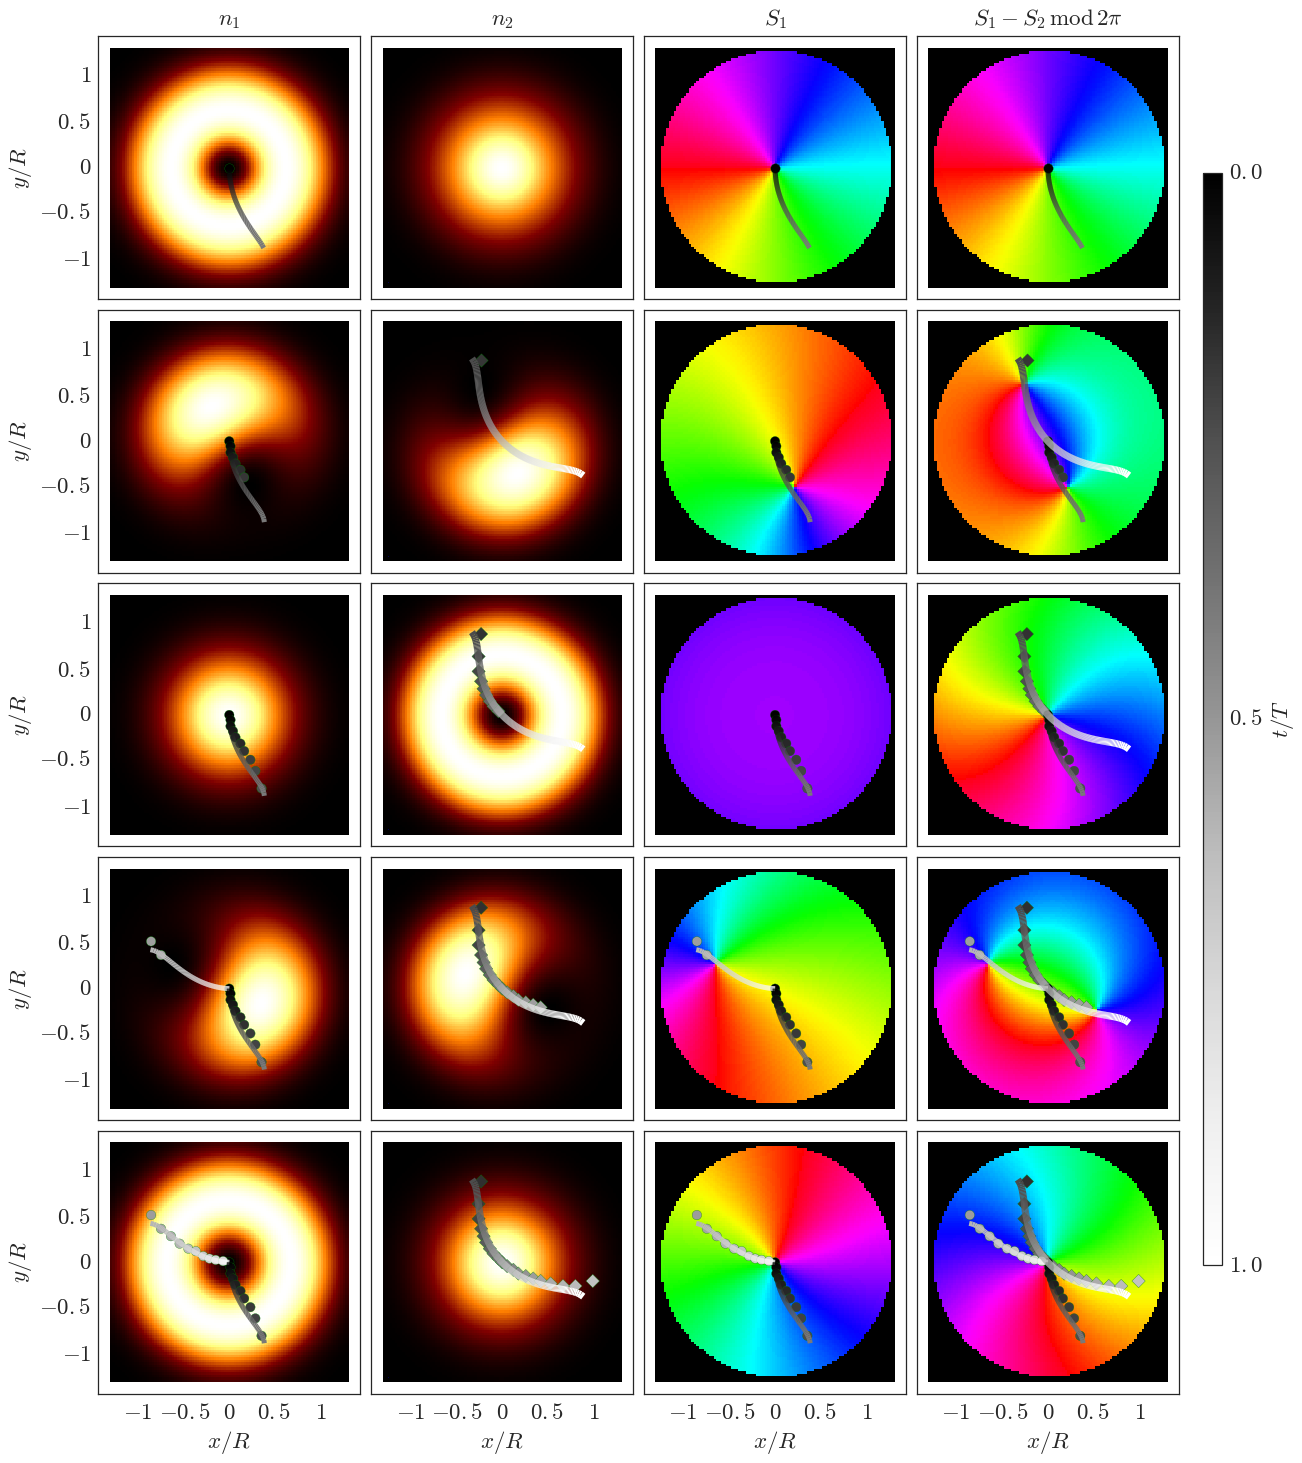

In [13]:
############ Helper Functions ############
TF_radius_ = 2.24638933492
TF_radius = 2.24638933492
Rabi_period = np.pi
Omega_Rabi = 2.*np.pi/Rabi_period
g_A = 20.
g_B = g_A
g_AB = g_A
xi_A =  0.434474936715

kappa = .485

def dynamic_equations_plot(y, t, Omega, kappa, R, xi):
    u, phi = y
    c = 4./3. - 128./(45.*np.pi)
    uDot = -.25*Omega*(4./3.-c*u**2) * np.sin(phi-kappa*t) / (1.-u**2)
    phiDot = (1./(R**2 * (1.-u**2))*(np.log(R/xi) + .5*np.log(1-u**2) - .5)\
             - .25*Omega /(u*(1-u**2)) * (4./3. - 3.*c*u**2)* np.cos(phi-kappa*t))
    return [uDot, phiDot]

def dynamic_equations_ret_plot(y, t, Omega, kappa, R, xi):
    u, phi = y
    c = 4./3. - 128./(45.*np.pi)
    uDot = .25*Omega*(4./3.-c*u**2) * np.sin(phi+kappa*t) / (1.-u**2)
    phiDot = -(1./(R**2 * (1.-u**2))*(np.log(R/xi) + .5*np.log(1-u**2) - .5)\
             - .25*Omega /(u*(1-u**2)) * (4./3. - 3.*c*u**2)* np.cos(phi+kappa*t))
    return [uDot, phiDot]

def get_theoretical_trajectory_plot(cycle1, time1, time2):

    u = np.array([])
    phi = np.array([])
    # first component
    y0 = [0.0001, 0.]                           # initial conditions
    time_series = np.arange(0., Rabi_period/2., 0.01)           # time of evolution
    # integrate dynamic equations
    r0 = odeint(dynamic_equations, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
    time1_series = time_series
    
    if cycle1 >= 1:
        y0 = [0.0001, 0.]                                     # initial conditions
        time_series = np.arange(0., .4*Rabi_period, 0.01) - time1        # time of evolution
        # integrate dynamic equations
        r = odeint(dynamic_equations_ret, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
        u = r[:,0]
        phi = r[:,1]
        y0 = [0.0001, 0.]                                    # initial conditions
        
    u = np.concatenate((u[::-1], r0[:,0]))
    phi = np.concatenate((phi[::-1], r0[:,1]))
    vTraj_x1 = []
    vTraj_y1 = []
    for idx in range(len(u)):
        vTraj_x1.append(u[idx] * np.cos(phi[idx]))
        vTraj_y1.append(u[idx] * np.sin(phi[idx]))
    
    # second component
    y0 = [0.0001, 0]                                     # initial conditions
    time_series = np.arange(0., .4*Rabi_period, 0.01) - time2        # time of evolution
    # integrate dynamic equations
    r = odeint(dynamic_equations_ret, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))
    u = r[:,0]
    phi = r[:,1]
    y0 = [0.0001, 0]                                    # initial conditions
    time_series = np.arange(0., .4*Rabi_period, 0.01) + time2        # time of evolution
    # integrate dynamic equations
    r = odeint(dynamic_equations, y0, time_series, args=(Omega_Rabi, kappa, TF_radius, xi_A))     
    time2_series = np.concatenate((time_series - 0.4*Rabi_period, time_series), axis=0)
    
    u = np.concatenate((u[::-1], r[:,0]))
    phi = np.concatenate((phi[::-1], r[:,1]))
    vTraj_x2 = []
    vTraj_y2 = []
    for idx in range(len(u)):
        vTraj_x2.append(u[idx] * np.cos(phi[idx]))
        vTraj_y2.append(u[idx] * np.sin(phi[idx]))

    return np.array(vTraj_x1), np.array(vTraj_y1), np.array(vTraj_x2), np.array(vTraj_y2)

############ Plot ############
fig = plt.figure(figsize=(18, 20.5));

for row in range(0, 5):
    # Calculate theoretical trajectories
    if row<3:
        cycle1 = 0
        time1 = 0 
        time2 = Rabi_period / 2
    else:
        cycle1 = 1
        time1 = Rabi_period 
        time2 = Rabi_period / 2
    
    vTraj_x1, vTraj_y1, vTraj_x2, vTraj_y2 = get_theoretical_trajectory_plot(cycle1, time1, time2)
    
    cont = row*10
    fontsi = 23
    rescale = 0.65
    markersize = 90
    imag_time =  False

    length_x_ = 9.
    delta_x = length_x_ / dim

    # rescaling of the pcolor plots
    dim_x = int(dim * rescale / 2.) *2
    rescale_ = dim_x / dim
    length_x = length_x_ * rescale_
    TF_radius = TF_radius_ * rescale_

    density_A_ = densities1[row]
    density_B_ = densities2[row]
    phase_A_ = phases1[row]
    phase_B_ = phases2[row]

    edge = (dim - dim_x) // 2
    density_A = density_A_[edge:dim-edge, edge:dim-edge]
    density_B = density_B_[edge:dim-edge, edge:dim-edge]
    phase_A = phase_A_[edge:dim-edge, edge:dim-edge]
    phase_B = phase_B_[edge:dim-edge, edge:dim-edge]

    _coord1x = coord1x[row]
    _coord1y = coord1y[row]
    _coord2x = coord2x[row]
    _coord2y = coord2y[row]

    # vectors containing the physical coordinates (in h.o. units, and centered in the lattice)
    x_vec = (np.arange(dim_x) - dim_x*0.5) * delta_x
    y_vec = x_vec

    # draw a mask around the phase pattern, with a radius slightly larget than the TF radius
    # set the first pixel to -pi, and the second to +pi
    # (so the range of plotting is fixed, and the mask doesn't change color)

    approx_cloud_radius = max(TF_radius_, 1)
    disk_mask = np.zeros((dim_x, dim_x))
    for ix in range(0, dim_x):
        for iy in range(0, dim_x):
            if ((ix-dim_x*0.5)**2 + (iy-dim_x*0.5)**2) > (1.25 * (2*approx_cloud_radius/length_x) * dim_x / 2)**2:
                disk_mask[ix, iy] = 0.99
    disk_mask = np.ma.masked_where(disk_mask < 0.5, disk_mask)

    phase_A[0, 0] = -np.pi
    phase_B[0, 0] = -np.pi
    phase_A[0, 1] = np.pi
    phase_B[0, 1] = np.pi

    ################ Draw theoretical trajectories ################
    vTraj_x1 /= rescale_ 
    vTraj_y1 /= rescale_
    vTraj_x2 /= rescale_
    vTraj_y2 /= rescale_
    
    for idx in range(len(vTraj_x1)):
        vTraj_x1[idx] = (vTraj_x1[idx] * 2*TF_radius/length_x + 1.)*dim_x*0.5
        vTraj_y1[idx] = (vTraj_y1[idx] * 2*TF_radius/length_x + 1.)*dim_x*0.5
    
    for idx in range(len(vTraj_x2)):
        vTraj_x2[idx] = (vTraj_x2[idx] * 2*TF_radius/length_x + 1.)*dim_x*0.5
        vTraj_y2[idx] = (vTraj_y2[idx] * 2*TF_radius/length_x + 1.)*dim_x*0.5
    # drop nan values
    vTraj_x1 = vTraj_x1[~np.isnan(vTraj_x1)]
    vTraj_y1 = vTraj_y1[~np.isnan(vTraj_y1)]
    vTraj_x2 = vTraj_x2[~np.isnan(vTraj_x2)]
    vTraj_y2 = vTraj_y2[~np.isnan(vTraj_y2)]
    
    if cycle1 == 0:
        c_ind1 = 1-np.linspace(0., .4, len(vTraj_y1))
    else:
        c_ind1 = np.linspace(0.6, 1, len(vTraj_y1)//2)
        c_ind1 = 1-np.concatenate([c_ind1, np.linspace(0., .4, len(vTraj_y1)-len(vTraj_y1)//2)], axis=0)
    points1 = np.array([vTraj_x1,vTraj_y1]).T.reshape(-1,1,2)
    segments1 = np.concatenate([points1[:-1], points1[1:]], axis=1)
    
    lc1 = LineCollection(segments1, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1))
    lc1.set_array(c_ind1)
    lc1.set_linewidth(5)
    lc11 = LineCollection(segments1, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1))
    lc11.set_array(c_ind1)
    lc11.set_linewidth(5)
    lc111 = LineCollection(segments1, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1))
    lc111.set_array(c_ind1)
    lc111.set_linewidth(5)
    
    c_ind2 = 1-np.linspace(0., 1, len(vTraj_y2))
    points2 = np.array([vTraj_x2,vTraj_y2]).T.reshape(-1,1,2)
    segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)

    lc2 = LineCollection(segments2, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0.,1.3))
    lc2.set_array(c_ind2)
    lc2.set_linewidth(7)
    lc21 = LineCollection(segments2, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1.3))
    lc21.set_array(c_ind2)
    lc21.set_linewidth(7)
    
    #################################################################
    # Make plot
    ###################

    data=[density_A, density_B, phase_A, np.remainder(phase_A-phase_B+np.pi, 2*np.pi)]

    x_centers = [_coord1x, _coord2x, _coord1x, _coord2x]
    y_centers = [_coord1y, _coord2y, _coord1y, _coord2y]
    cmaps = ['afmhot', 'afmhot', 'hsv', 'hsv']

    norm = matplotlib.colors.Normalize(vmin = 0., vmax = 1.)

    for i in np.arange(len(data)):
        ax = plt.subplot(5, 4, i+1+row*4)
        if i == 0:
            marker = 'o'
            subplot_title = "$n_1$"
        elif i == 1:
            marker = 'D'
            subplot_title = "$n_2$"
        elif i == 2:
            marker = 'o'
            subplot_title = "$S_1$"
        else:
            marker = 'D'
            marker2 = 'o'
            subplot_title = "$S_1 - S_2 \, \mathrm{mod} \, 2 \pi$"
        if row == 0:
            ax.set_title(subplot_title, fontsize=fontsi, va='bottom')

        x_ticks_1 = [dim_x//2 - int(TF_radius_/delta_x),
                     dim_x//2 - int(TF_radius_/(2*delta_x)),
                     dim_x//2,
                     dim_x//2 + int(TF_radius_/(2*delta_x)),
                     dim_x//2 + int(TF_radius_/(delta_x))]
        x_ticks_2 = ['', '', '', '', '']
        y_ticks_1 = [dim_x//2 - int(TF_radius_/delta_x),
                     dim_x//2 - int(TF_radius_/(2*delta_x)),
                     dim_x//2,
                     dim_x//2 + int(TF_radius_/(2*delta_x)),
                     dim_x//2 + int(TF_radius_/(delta_x))]
        y_ticks_2 = ['$'+str(-1)+'$', '$'+str(-0.5)+'$', '$0$', '$'+str(0.5)+'$', '$'+str(1)+'$']
        if row == 4:
            plt.xlabel('$x/R$', fontsize=fontsi)
            plt.xticks(y_ticks_1, y_ticks_2, fontsize=fontsi)
            if i==0:
                plt.ylabel('$y/R$', fontsize=fontsi)
                plt.yticks(y_ticks_1, y_ticks_2, fontsize=fontsi)
            else:
                plt.yticks(x_ticks_1, x_ticks_2, fontsize=fontsi)
        else:
            plt.xticks(x_ticks_1, x_ticks_2, fontsize=fontsi)
            if i==0:
                plt.ylabel('$y/R$', fontsize=fontsi)
                plt.yticks(y_ticks_1, y_ticks_2, fontsize=fontsi)
            else:
                plt.yticks(x_ticks_1, x_ticks_2, fontsize=fontsi)
        ##############

        plt.pcolormesh(data[i], cmap=cmaps[i], linewidth=0, rasterized=True)

        # Plot theoretical trajectories
        if i==0:
            ax.add_collection(lc1)        
        if i==2:
            ax.add_collection(lc11)        
    
        if i==1:
            plt.scatter(2,2, s=1)
            if row != 0:
                ax.add_collection(lc2)        
        if i==3:
            ax.add_collection(lc111) 
            if row != 0:
                ax.add_collection(lc21)
                
        #plot mask
        if i >= 2:
            plt.pcolor(disk_mask, cmap='Greys_r', linewidth=0, rasterized=True)
        #plot trajectories
        color_indices = np.linspace(0, 1, _coord1x.size) * _coord1x.size / 40.
        scatter_plot = plt.scatter(x_centers[i] / delta_x + 0.5*dim_x, y_centers[i] / delta_x + 0.5*dim_x,\
                    c=color_indices, cmap='Greys_r', norm=norm, s=markersize, edgecolors='Green', marker=marker)
        if i == 3:
            plt.scatter(x_centers[2] / delta_x + 0.5*dim_x, y_centers[2] / delta_x + 0.5*dim_x,\
                    c=color_indices, cmap='Greys_r', norm=norm, s=markersize, edgecolors='Green', marker=marker2)

        
cbaxes = fig.add_axes([0.93, 0.135, 0.015, 0.74])
cbar = plt.colorbar(scatter_plot, cax = cbaxes, ticks = [0, 0.5, 1], format='$%1.1f$')
cbar.ax.tick_params(labelsize=fontsi)
cbar.set_label(r'$t/T$', labelpad=5, y=0.5, fontsize=fontsi)
cbar.ax.invert_yaxis()

plt.tight_layout(rect=(0, 0, 0.92, 0.995))
plt.show()

**Top row**: Initial condition, with a vortex at the center of the first component.

**Second row**: The system imaged after one quarter of a Rabi period ($t=T/4$). The vortex core follows the trajectory marked by the small circles and squares: from black ($t=0$) to gray ($t=T/4$), it travels until the edge of the first component; just before $t=T/4$, while the first vortex is still inside the first cloud, a second vortex starts entering the second cloud, and a domain wall in the relative phase is clearly visible in the fourth column.

**Third row**: After half a Rabi period ($t=T/2$), the first vortex has completely disappeared from the first component, while the new one gradually migrates to the center of the second component.

**Fourth row**: At $t=3T/4$, two vortices are again visible, one in each component.

**Bottom row**: After a full Rabi period ($t=T$), the vortex leaves the second component, reappears inside the first, and returns back to its center. Continuous lines show the theoretical trajectories for $\kappa = 0.485 \omega_\perp$.

In the following, we compare the time dependence of the vortex energy given by the simulated and predicted trajectories. The simulation takes about five minutes to finish.

In [14]:
densities1, densities2 = [], []
phases1, phases2 = [], []
coord1x, coord1y = [], []
coord2x, coord2y = [], []

# linear size of the lattice
dim = 150
length = 15.

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 5

# start evolution
gAB_over_g =1.
Rabi_period = 5*np.pi
coupling = 20.
time0 = time.time()
coord1, coord2, time_coord, vTrajTot_x1, vTrajTot_y1,\
        vTrajTot_x2, vTrajTot_y2, time1_th, time2_th = single_vortex(dim, length, Rabi_period, coupling,\
                                                                     Rabi_periods_to_be_simulated, gAB_over_g,\
                                                                     densities1, densities2, phases1, phases2,\
                                                                     coord1x, coord1y, coord2x, coord2y)
print("Total time:", time.time()-time0)

Total time: 347.01969480514526


This is Fig. 7 in the manuscript:

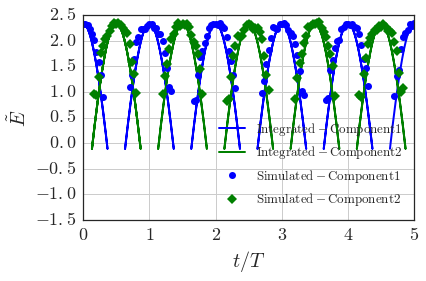

In [15]:
#sns.reset_origin()

R = 2.24638933492        # T-F radius for g=20
xi = 0.423384837924      # and coherence length 
k = 0.485
Omega  = 2.*np.pi / Rabi_period

c = 4./3. - 128./(45.*np.pi)
T = 2*np.pi/Omega

u = np.sqrt(vTrajTot_x1**2 + vTrajTot_y1**2)
phi = np.angle(vTrajTot_x1 + 1j * vTrajTot_y1)
t = time1_th
ThEnergy_1 = (1-u**2)*(2.*np.log(R/xi) + np.log(1-u**2)) + 2.*u**2 - 1 + Omega*R**2*u*(4./3. - c*u**2)*np.cos(phi-k*t)

u = np.sqrt(vTrajTot_x2**2 + vTrajTot_y2**2)
phi = np.angle(vTrajTot_x2 + 1j * vTrajTot_y2)
t = time2_th
ThEnergy_2 = (1-u**2)*(2.*np.log(R/xi) + np.log(1-u**2)) + 2.*u**2 - 1 + Omega*R**2*u*(4./3. - c*u**2)*np.cos(phi-k*t)

u = np.sqrt(coord1[0]**2 + coord1[1]**2) / R
phi = np.angle(coord1[0] + 1j * coord1[1])
t = time_coord
SiEnergy_1 = (1-u**2)*(2.*np.log(R/xi) + np.log(1-u**2)) + 2.*u**2 - 1 + Omega*R**2*u*(4./3. - c*u**2)*np.cos(phi-k*t)

u = np.sqrt(coord2[0]**2 + coord2[1]**2) / R
phi = np.angle(coord2[0] + 1j * coord2[1])
t = time_coord
SiEnergy_2 = (1-u**2)*(2.*np.log(R/xi) + np.log(1-u**2)) + 2.*u**2 - 1 + Omega*R**2*u*(4./3. - c*u**2)*np.cos(phi-k*t)

plt.plot(time1_th/T, ThEnergy_1, 'b', lw=2, label=r"$\mathrm{Integrated - Component 1}$")
plt.plot(time2_th/T, ThEnergy_2, 'g', lw=2, label=r"$\mathrm{Integrated - Component 2}$")
plt.plot(time_coord/T, SiEnergy_1, 'bo', label=r"$\mathrm{Simulated - Component 1}$")
plt.plot(time_coord/T, SiEnergy_2, 'gD', label=r"$\mathrm{Simulated - Component 2}$")
plt.grid()
plt.ylim(-1.5, 2.5)
plt.xlim(0,5)
plt.xticks([0, 1,2,3,4,5], ['$0$', '$1$','$2$','$3$','$4$','$5$'], fontsize=18)
plt.yticks([-1.5, -1, -0.5, 0, 0.5,1,1.5,2,2.5],
           ['$-1.5$','$-1.0$','$-0.5$','$0.0$', '$0.5$','$1.0$','$1.5$','$2.0$','$2.5$'],
           fontsize=18)
plt.xlabel(r"$t/T$", fontsize=20)
plt.ylabel(r"$\tilde{E}$", fontsize=20)
plt.legend(fontsize=13, loc=4)
plt.tight_layout()
plt.show()

We simulate the coherent transfer of vorticity in the weak particle interaction regime. The functions that calculate the theoretical trajectory of the vortex and that plots Fig. 5 in the manuscript are given below. 

In [16]:
def dynamic_equations_weak(y, t, Omega, kappa, g, g12):
    u, phi = y
    uDot = -0.5*Omega * np.sin(phi - kappa*t) * (beta**2 + u**2)**1.5 / beta**2
    phiDot = 0.5 * (1 + beta**4) / beta**2 \
             - 1./(4*np.pi) * (g / (beta**2 + u**2) + g12 / beta**2) \
             - 0.5 * Omega * np.cos(phi - kappa*t) * np.sqrt(beta**2 + u**2) / u
    return [uDot, phiDot]

def dynamic_equations_ret_weak(y, t, Omega, kappa, g, g12):
    t = -t
    u, phi = y
    uDot = 0.5*Omega * np.sin(phi - kappa*t) * (beta**2 + u**2)**1.5 / beta**2
    phiDot = -0.5 * (1 + beta**4) / beta**2 \
             + 1./(4*np.pi) * (g / (beta**2 + u**2) + g12 / beta**2) \
             + 0.5 * Omega * np.cos(phi - kappa*t) * np.sqrt(beta**2 + u**2) / u
    return [uDot, phiDot]

def get_theoretical_trajectory_weak(cycle1, time1, cycle2, time2, Rabi_period, Omega_Rabi, kappa, g1, g12):
    u = np.array([])
    phi = np.array([])
    # first component
    if cycle1 < 1.:
        y0 = [0.0001, 0.]                           # initial conditions
        time_series = np.arange(0., Rabi_period/3.8, 0.01)           # time of evolution
        # integrate dynamic equations
        r = odeint(dynamic_equations_weak, y0, time_series, args=(Omega_Rabi, kappa, g1, g12))
        time1_series = time_series
    if cycle1 >= 1:
        y0 = [0.0001, 0.]                                     # initial conditions
        time_series = np.arange(0., Rabi_period/3.8, 0.01) - time1        # time of evolution
        # integrate dynamic equations
        r = odeint(dynamic_equations_ret_weak, y0, time_series, args=(Omega_Rabi, kappa, g1, g12))
        u = r[:,0]
        phi = r[:,1]
        y0 = [0.0001, 0.]                                    # initial conditions
        time_series = np.arange(0., Rabi_period/3.8, 0.01) + time1        # time of evolution
        # integrate dynamic equations
        r = odeint(dynamic_equations_weak, y0, time_series, args=(Omega_Rabi, kappa, g1, g12))
        time1_series = np.concatenate((time_series - Rabi_period/4, time_series), axis=0)
    u = np.concatenate((u[::-1], r[:,0]))
    phi = np.concatenate((phi[::-1], r[:,1]))
    vTraj_x1 = []
    vTraj_y1 = []
    for idx in range(len(u)):
        vTraj_x1.append(u[idx] * np.cos(phi[idx]))
        vTraj_y1.append(u[idx] * np.sin(phi[idx]))
    
    # second component
    y0 = [0.0001, 0]                                     # initial conditions
    time_series = np.arange(0., Rabi_period/3.9, 0.01) - time2        # time of evolution
    # integrate dynamic equations
    r = odeint(dynamic_equations_ret_weak, y0, time_series, args=(Omega_Rabi, kappa, g1, g12))
    u = r[:,0]
    phi = r[:,1]
    y0 = [0.0001, 0]                                    # initial conditions
    time_series = np.arange(0., Rabi_period/3.9, 0.01) + time2        # time of evolution
    # integrate dynamic equations
    r = odeint(dynamic_equations_weak, y0, time_series, args=(Omega_Rabi, kappa, g1, g12))
    time2_series = np.concatenate((time_series - Rabi_period/4, time_series), axis=0)
    
    u = np.concatenate((u[::-1], r[:,0]))
    phi = np.concatenate((phi[::-1], r[:,1]))
    vTraj_x2 = []
    vTraj_y2 = []
    for idx in range(len(u)):
        vTraj_x2.append(u[idx] * np.cos(phi[idx]))
        vTraj_y2.append(u[idx] * np.sin(phi[idx]))

    return np.array(vTraj_x1), np.array(vTraj_y1), np.array(vTraj_x2), np.array(vTraj_y2), time1_series, time2_series

def plot_status(grid, state1, state2, hamiltonian, TF_radius, imag_time,
                coord1_, coord2_, cont, time, export, show, frames_per_Rabi_period,
                vTraj_x1_, vTraj_y1_, vTraj_x2_, vTraj_y2_, cycle1, cycle2):
    
    coord1 = coord1_.copy()
    coord2 = coord2_.copy()
    vTraj_x1 = np.array(vTraj_x1_).copy()
    vTraj_y1 = np.array(vTraj_y1_).copy()
    vTraj_x2 = np.array(vTraj_x2_).copy()
    vTraj_y2 = np.array(vTraj_y2_).copy()
    
    fontsize = 25
    markersize = 80
    
    Omega_Rabi = np.sqrt(hamiltonian.omega_r**2 + hamiltonian.omega_i**2)
    Rabi_period = 2*np.pi / Omega_Rabi if Omega_Rabi != 0 else 0.
    density_A_ = state1.get_particle_density()
    density_B_ = state2.get_particle_density()
    phase_A_ = state1.get_phase()
    phase_B_ = state2.get_phase()
    
    # rescaling of the pcolor plots
    rescale = .8
    dim_x = int(grid.dim_x * rescale / 2.) *2
    rescale_ = dim_x / (grid.dim_x * 1.)
    length_x = grid.length_x * rescale_
    
    edge = int((grid.dim_x - dim_x) / 2)
    density_A = density_A_[edge:grid.dim_x-edge, edge:grid.dim_x-edge]
    density_B = density_B_[edge:grid.dim_x-edge, edge:grid.dim_x-edge]
    phase_A = phase_A_[edge:grid.dim_x-edge, edge:grid.dim_x-edge]
    phase_B = phase_B_[edge:grid.dim_x-edge, edge:grid.dim_x-edge]
    
    # draw a mask around the phase pattern, with a radius slightly larget than the TF radius
    # and draw a circle at the TF radius 
    # assign to the mask the value pi/3 (=blue), then set the first pixel to -pi, and the second to +pi
    # (so the range of plotting is fixed, and the mask doesn't change color)
    #phase_B_mask = np.zeros(np.shape(phase_B)) * np.nan
    l_x, l_y = phase_A.shape[0], phase_A.shape[1]
    X, Y = np.ogrid[:l_x, :l_y]
    approx_cloud_radius = max(TF_radius,1)
    phase_A[0,0]=-np.pi
    phase_B[0,0]=-np.pi
    phase_A[0,1]=np.pi
    phase_B[0,1]=np.pi
    
    disk_mask = np.zeros((dim_x, dim_x))
    for ix in range(0, dim_x):
        for iy in range(0, dim_x):
            if ((ix-dim_x*0.5)**2 + (iy-dim_x*0.5)**2) > (1.25 * (2*approx_cloud_radius/length_x) * l_x / 2)**2:
                disk_mask[ix,iy] = 0.99
    disk_mask = np.ma.masked_where(disk_mask < 0.5, disk_mask)
    #######################################################################
    # Vortex trajectory
    for idx in range(len(vTraj_x1)):
        vTraj_x1[idx] = (vTraj_x1[idx] * 2/length_x + 1.)*dim_x*0.5
        vTraj_y1[idx] = (vTraj_y1[idx] * 2/length_x + 1.)*dim_x*0.5
    
    for idx in range(len(vTraj_x2)):
        vTraj_x2[idx] = (vTraj_x2[idx] * 2/length_x + 1.)*dim_x*0.5
        vTraj_y2[idx] = (vTraj_y2[idx] * 2/length_x + 1.)*dim_x*0.5
    # drop nan values
    vTraj_x1 = vTraj_x1[~np.isnan(vTraj_x1)]
    vTraj_y1 = vTraj_y1[~np.isnan(vTraj_y1)]
    vTraj_x2 = vTraj_x2[~np.isnan(vTraj_x2)]
    vTraj_y2 = vTraj_y2[~np.isnan(vTraj_y2)]
    
    if cycle1 == 0:
        c_ind1 = 1-np.linspace(0., .4, len(vTraj_y1))
    else:
        c_ind1 = np.linspace(0.6, 1, len(vTraj_y1)//2)
        c_ind1 = 1-np.concatenate([c_ind1, np.linspace(0., .4, len(vTraj_y1)-len(vTraj_y1)//2)], axis=0)
    points1 = np.array([vTraj_x1,vTraj_y1]).T.reshape(-1,1,2)
    segments1 = np.concatenate([points1[:-1], points1[1:]], axis=1)
    
    lc1 = LineCollection(segments1, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1))
    lc1.set_array(c_ind1)
    lc1.set_linewidth(5)
    lc11 = LineCollection(segments1, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1))
    lc11.set_array(c_ind1)
    lc11.set_linewidth(5)
    lc111 = LineCollection(segments1, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1))
    lc111.set_array(c_ind1)
    lc111.set_linewidth(5)
    
    c_ind2 = 1-np.linspace(0., 0.7, len(vTraj_y2))
    points2 = np.array([vTraj_x2,vTraj_y2]).T.reshape(-1,1,2)
    segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)

    lc2 = LineCollection(segments2, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1.25))
    lc2.set_array(c_ind2)
    lc2.set_linewidth(5)
    lc21 = LineCollection(segments2, cmap=plt.get_cmap('Greys'), norm=plt.Normalize(0,1.25))
    lc21.set_array(c_ind2)
    lc21.set_linewidth(5)
    
    data=[density_A,density_B,phase_A/np.pi,np.remainder(phase_A-phase_B + np.pi, 2.*np.pi)/np.pi-1.]

    x_centers=[coord1[0], coord2[0], coord1[0], coord2[0]]
    y_centers=[coord1[1], coord2[1], coord1[1], coord2[1]]
    
    #################################################################
    # Make plot
    fig = plt.figure(figsize=(19,5.5));    
    title='$t/T= %4.2f$' % (time/Rabi_period)
    cmaps=['afmhot','afmhot','hsv','hsv']
    x_ticks_1 = [dim_x/2 - int(TF_radius/grid.delta_x), 
                 dim_x/2 - int(TF_radius/(2*grid.delta_x)),
                 dim_x/2, 
                 dim_x/2 + int(TF_radius/(2*grid.delta_x)),
                 dim_x/2 + int(TF_radius/(grid.delta_x))]        
    x_ticks_2 = ['','','','', '']
    y_ticks_1 = [dim_x/2 - int(TF_radius/grid.delta_x),
                 dim_x/2 - int(TF_radius/(2*grid.delta_x)),
                 dim_x/2,
                 dim_x/2 + int(TF_radius/(2*grid.delta_x)),
                 dim_x/2 + int(TF_radius/(grid.delta_x))]
    y_ticks_2 = ['$'+str(-2)+'$', '$'+str(-1)+'$', '$0$', '$'+str(1)+'$', '$'+str(2)+'$']    
    
    norm = colors.Normalize(vmin = 0., vmax = 1.)  

    for i in np.arange(len(data)):
        if i == 0:
            marker = 'o'
            subplot_title = "$n_1$"
        elif i == 1:
            marker = 'D'
            subplot_title = "$n_2$"
        elif i == 2:
            marker = 'o'
            subplot_title = "$S_1$"
        else:
            marker = 'D'
            marker2 = 'o'
            subplot_title = "$S_1 - S_2 \, \mathrm{mod} \, 2 \pi$"
        ax = plt.subplot(1,4,i+1) 
        ax.set_title(subplot_title, fontsize=fontsize, va='bottom')
        plt.xlabel(r'$x/d_\perp$', fontsize=fontsize)
        plt.xticks(y_ticks_1,y_ticks_2, fontsize=fontsize)
        if i==0:
            plt.ylabel(r'$y/d_\perp$', fontsize=fontsize)
            plt.yticks(y_ticks_1,y_ticks_2, fontsize=fontsize)
        else:
            plt.yticks(x_ticks_1,x_ticks_2, fontsize=fontsize)
        pcolor = plt.pcolormesh(data[i],cmap=cmaps[i],linewidth=0,rasterized=True)
        
        norm = colors.Normalize(vmin = 0., vmax = 1.)
        
        n_points = len(coord1[0])
        color_indices=(np.arange(n_points) % frames_per_Rabi_period) / float(frames_per_Rabi_period)
        
        scatter_plot = plt.scatter(x_centers[i] / grid.delta_x + 0.5*dim_x, y_centers[i] / grid.delta_x + 0.5*dim_x,
                                   c=color_indices, cmap='Greys_r', norm=norm,s=markersize, edgecolors='Green',
                                   marker=marker)
        
        if i==0:
            ax.add_collection(lc1)        
        if i==2:
            ax.add_collection(lc11)        
        if i==1:
            ax.add_collection(lc2)        
        if i==3:
            ax.add_collection(lc21)
            ax.add_collection(lc111)
            plt.scatter(x_centers[2] / grid.delta_x + 0.5*dim_x, y_centers[2] / grid.delta_x + 0.5*dim_x,
                        c=color_indices, cmap='Greys_r', norm=norm,s=markersize, edgecolors='Green', marker=marker2)
        if i >= 2:
            plt.pcolor(disk_mask, cmap='Greys_r',linewidth=0,rasterized=True)
        plt.scatter([dim_x/2 - int(2./grid.delta_x)], [dim_x/2 - int(2./grid.delta_x)], s=0.01)
    
    cbaxes = fig.add_axes([0.93,0.18,0.015,0.70])
    cbar = plt.colorbar(scatter_plot, cax = cbaxes, ticks = [0,0.5,1], format='$%1.1f$')
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(r'$t/T$', labelpad=5,y=0.5, fontsize=fontsize)
    cbar.ax.invert_yaxis()
    
    plt.tight_layout(rect=(0,0,0.92,0.995))
    plt.show()

Here is defined the function that performs the simulation.

In [17]:
def single_vortex_weak(dim, Rabi_period, coupling, Rabi_periods_to_be_simulated, gAB_over_g):
    
    length = 6 # physical length of the lattice
    max_vortex_track = length * 0.27
    TF_radius = max_vortex_track
    grid = ts.Lattice(dim, length)
    
    ## Define the Hamiltonian
    potential = ts.HarmonicPotential(grid, 1., 1.)
    
    g1 = coupling
    g2 = coupling
    g12 = gAB_over_g * coupling
    omega = 0
    hamiltonian = ts.Hamiltonian2Component(grid, potential, potential, 1., 1., g1, g12, g2, omega)
    
    ## Define the initial state
    width = max(TF_radius,1)
    w = 0.5 / width**2
    state1 = ts.GaussianState(grid, w)
    state2 = ts.GaussianState(grid, w)
    
    ## Imprint(vortex phase
    def vortex_phase(x, y):
        z = x + 1j*y
        angle = np.angle(z)
        return np.exp(1j * (angle))
    
    def phase_BEC2(x, y):
        return np.exp(1j * 0.)
    state1.imprint(vortex_phase)
    
    ## Initialize the solver
    frames_per_Rabi_period = 30
    real_iterations = 700  # number of iterations performed by each instance of ts
    deltaT = Rabi_period /(real_iterations * frames_per_Rabi_period)
    
    #deltaT = 2.5e-4
    solver = ts.Solver(grid, state1, state2, hamiltonian, deltaT)
    
    #################################################################
    ## IMAGINARY EVOLUTION
    iterations = 2000
    NumEvo = 4
    for i in range(0, NumEvo):
        solver.evolve(iterations, True)
    
    #################################################################
    ## REAL-TIME EVOLUTION
    omega = -2*np.pi / Rabi_period if Rabi_period != 0 else 0.
    hamiltonian.omega_r = omega  # Switch on the Rabi coupling
    solver.update_parameters
    
    iterations = real_iterations
    NumEvo = int(frames_per_Rabi_period * Rabi_periods_to_be_simulated) 

    coord1 = ts.vortex_position(grid, state1, max_vortex_track).reshape((2,1))
    coord2 = ts.vortex_position(grid, state2, max_vortex_track).reshape((2,1))
    time_coord = np.array([0.])
    
    xi_B=1./np.sqrt(2 * g2 * state2.get_particle_density().max()/(grid.delta_x**2))  ### coherence length of BEC_A
    xi_A=xi_B
    kappa = 1. / np.sqrt(0.5 * g1 / np.pi + 1)

    ## Calculate theoretical trajectories
    cycle1 = 0.
    time1 = 0.
    cycle2 = 0.
    time2 = .5 * Rabi_period
    vTraj_x1, vTraj_y1, vTraj_x2,\
              vTraj_y2, time1_s, time2_s = get_theoretical_trajectory_weak(cycle1, time1, cycle2, time2, Rabi_period,
                                                                           np.abs(omega), kappa, g1, g12)
    
    ## Evolve the system and track the vortex
    for i in range(0, NumEvo):
        solver.evolve(iterations)
        time = deltaT*(i+1)*iterations
        pos1 = ts.vortex_position(grid, state1, max_vortex_track) 
        pos2 = ts.vortex_position(grid, state2, max_vortex_track)
        coord1 = np.concatenate((coord1, pos1.reshape((2,1))), axis=1)
        coord2 = np.concatenate((coord2, pos2.reshape((2,1))), axis=1)
    
    ## Plot figure
    plot_status(grid, state1, state2, hamiltonian, TF_radius, False, coord1, coord2, i+1, time,\
                True, False, frames_per_Rabi_period, vTraj_x1, vTraj_y1, vTraj_x2, vTraj_y2, cycle1, cycle2)


The simulation takes about 2 minutes to finish.

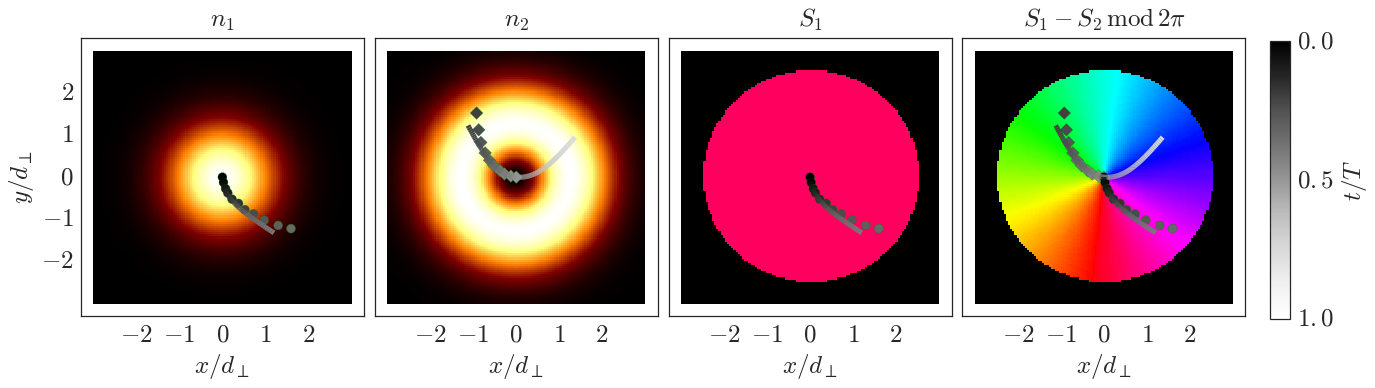

Total time: 69.62518620491028


In [18]:
# linear size of the lattice
dim=150

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 0.5

# start evolution
gAB_over_g = 1.
Rabi_period = np.pi
coupling = 1
beta = 1.
time0 = time.time()
single_vortex_weak(dim, Rabi_period, coupling, Rabi_periods_to_be_simulated, gAB_over_g)
print("Total time:", time.time()-time0)

Oscillations of the relative density
------------------------------------
We wish to study here the transfer of population (or "pseudo-spin dynamics") induced by a coherent Rabi coupling in a two component BEC, comparing specifically the case where both components have a uniform phase to the case where one component contains a vortex.
The following function is exploited to perform all the simultations of this section:

In [19]:
def density_oscillation(dim, periodicBoundary, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                        gAB_over_g, vortex, harmonicPot, phase_diff, length=0.):

    TF_radius = (4*coupling/np.pi)**0.25  # compute radius of the BEC in Thomas-Fermi approximation
    if length == 0:
        length = np.array([6, np.ceil(4*TF_radius)]).max() + 4.  # define physical length of the lattice 
                                                                # bigger than TF_radius
    grid = ts.Lattice(dim, length, periodicBoundary, periodicBoundary)      # define Lattice of the simulation

    g1 = coupling   # intra-component interaction for the first component
    g2 = coupling   # intra-component interaction for the second component
    g12 = gAB_over_g * coupling  # inter-component interaction
    omega = 0  # Rabi coupling for the imaginary time evolution

    def null_potential(x, y): # define flat potential
        return 0.
    def flat_function(x, y):  # define flat function normalized to one
        return 1./length
    
    # Define initial state and external potential
    if harmonicPot:
        potential = ts.HarmonicPotential(grid, 1., 1.)
        w = 0.5 / max(TF_radius, 1)**2
        state1 = ts.GaussianState(grid, w)
        state2 = ts.GaussianState(grid, w)
    else:
        potential = ts.Potential(grid)
        potential.init_potential(null_potential)
        state1 = ts.State(grid)
        state1.init_state(flat_function)
        state2 = ts.State(grid)
        state2.init_state(flat_function)

    # define the hamiltonian
    hamiltonian = ts.Hamiltonian2Component(grid, potential, potential, 1., 1., g1, g12, g2, omega)

    # define vortex phase
    def vortex_phase(x, y):
        z = x + 1j*y
        angle = np.angle(z)
        return np.exp(1j * (angle))
    
    def ini_phase2(x, y):
        return np.exp(-1j * phase_diff)
    
    if vortex:
        state1.imprint(vortex_phase)   # imprint vortex in the first component
    state2.imprint(ini_phase2)         # set phase of the second component
    
    frames_per_Rabi_period = 60        # number of snapshots per Rabi period
    real_iterations = 700              # number of iterations performed by each instance of ts
    deltaT = Rabi_period /(real_iterations * frames_per_Rabi_period)  # evolution time for each step

    solver = ts.Solver(grid, state1, state2, hamiltonian, deltaT)     # define the solver

    #####
    ## PERFORM IMAGINARY-TIME EVOLUTION
    #####
    
    imagIterations = 2000               # iterations to be performed between two snapshots
    NumEvo = 4                          # number of snapshots
    for i in range(0, NumEvo):
        solver.evolve(imagIterations, True)     # evolve the system

    #####
    ## PERFORM REAL-TIME EVOLUTION
    #####
    
    omega = -2*np.pi / Rabi_period      # set Rabi coupling
    hamiltonian.omega_r = omega         # switch on the Rabi coupling in the Hamiltonian
    solver.update_parameters            # make the changes valid also for the solver

    iterations = real_iterations        # set number of iterations
    NumEvo = int(frames_per_Rabi_period * Rabi_periods_to_be_simulated)  # number of snapshots

    N1 = []       # list of number of particles in the first component 
    N2 = []       # list of number of particles in the second component 
    phase1 = []   # list of phase at the center of the fist component
    phase2 = []   # list of phase at the center of the second component
    N1.append(state1.get_squared_norm()*.5)                            # get number of particles in first component
    N2.append(state2.get_squared_norm()*.5)                            # get number of particles in second component
    phase1.append(state1.get_phase()[grid.dim_x // 2, grid.dim_x // 2]) # get phase in first component
    phase2.append(state2.get_phase()[grid.dim_x // 2, grid.dim_x // 2]) # get phase in second component
    for i in range(0, NumEvo):
        solver.evolve(iterations)                # evolve the system
        N1.append(state1.get_squared_norm()*.5)  # get number of particles in first component
        N2.append(state2.get_squared_norm()*.5)  # get number of particles in second component
        phase1.append(state1.get_phase()[grid.dim_x // 2, grid.dim_x // 2]) # get phase in first component
        phase2.append(state2.get_phase()[grid.dim_x // 2, grid.dim_x // 2]) # get phase in second component

    return N1, N2, phase1, phase2

The following are the general options for the plots

In [20]:
figsize=(7, 4.4)  # size of the figure
fontsize = 18    # fontsize
ms = 4           # marker size
lw = 2           # line width

In the simplest non trivial scenario, the condensate has uniform density and no vortex is imprinted, being the phases of the two components uniform as well. In the following, several values of the initial phase difference are given for a simulation of one Rabi period ($T=\pi$), with $g=g_{12}=20 \hbar^2 /M $. This is a time-consuming step taking about eight minutes to complete.

In [21]:
dim = 100                 # set linear dimension of the lattice
periodicBoundary = True   # set whether to use periodic boundary or not
vortex = False            # set whether to imprint a vortex in the first component or not
harmonicPot = False       # set whether to use harmonic external potential or a flat potential
Rabi_periods_to_be_simulated = 1  # number of Rabi periods to be simulated
g12_over_g =1.            # ratio between inter and intra-density interaction
Rabi_period = np.pi       # Rabi period
coupling = 20.            # intra-density interaction

list_N1 = []
list_N2 = []
phase_diff_serie = np.array([1/2., 1/3., 1/4., 1/6., 0.])*np.pi
time0 = time.time()
for phase_diff in phase_diff_serie:
    N1, N2, phase1, phase2 = density_oscillation(dim, periodicBoundary, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                               g12_over_g, vortex, harmonicPot, phase_diff)
    list_N1.append(N1)
    list_N2.append(N2)
print("Total time:", time.time()-time0)    

Total time: 460.30376410484314


We first plot the dynamics of the population imbalance $\eta$ with $g = g_{12}$, for various values of the initial phase difference $S(0)$ (Fig. 8a in the paper):

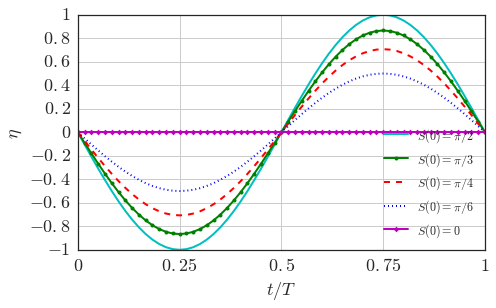

In [22]:
def frac(fraction):
    if fraction == 0.5:
        return '\pi/2$'
    elif fraction == 1/3.:
        return '\pi/3$'
    elif fraction == 1/4.:
        return '\pi/4$'
    elif fraction == 1./6.:
        return '\pi/6$'
    elif fraction == 0.:
        return '0$'
    else:
        return '$'

def linestyle(fraction):
    if fraction == 0.5:
        return 'c-'
    elif fraction == 1/3.:
        return 'g-o'
    elif fraction == 1/4.:
        return 'r--'
    elif fraction == 1./6.:
        return 'b:'
    elif fraction == 0.:
        return 'm-D'
    else:
        return '$'
    
phase_diff_serie = np.array([1/2., 1/3., 1/4., 1/6., 0.])*np.pi
time_axis = np.linspace(0, 1., 61)
plt.figure(figsize=figsize)
for indx in range(len(phase_diff_serie)):
    y = np.array(list_N2[indx]) - np.array(list_N1[indx])
    plt.plot(time_axis, y, linestyle(phase_diff_serie[indx]/np.pi), ms=ms, 
             lw=lw, label='$S(0) =' + frac(phase_diff_serie[indx]/np.pi))

plt.xlabel('$t/T$', fontsize=fontsize)
plt.ylabel('$\eta$', fontsize=fontsize)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['$0$', '$0.25$', '$0.5$', '$0.75$', '$1$'], fontsize=fontsize)
plt.yticks([-1, -.8, -.6, -.4, -.2, 0., 0.2, 0.4, 0.6, 0.8, 1], 
           ['$-1$', '$-0.8$', '$-0.6$', '$-0.4$', '$-0.2$', '$0$', '$0.2$', '$0.4$', '$0.6$', '$0.8$', '$1$'], 
           fontsize=fontsize)
plt.ylim(-1, 1)
plt.grid()
plt.legend(fontsize=fontsize-6, fancybox=True, loc=4)
plt.tight_layout()
plt.show()

It is interesting to study, in the same conditions, how the transfer of population occurs varing the strenght of the inter-component interaction $g_{12}$, fixing the phase difference at $S=\pi/6$. The following snippet runs in about twelve minutes:

In [23]:
# linear size of the lattice
dim = 100
length = np.sqrt(10.)
periodicBoundary = True
vortex = False
harmonicPot = False

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1.7

# start evolution
Rabi_period = np.pi
coupling = 20.
phase_diff = np.pi-np.pi/6

list2_N1 = []
list2_N2 = []
gAB_over_g_serie = np.array([0., 0.25, 0.5, 0.75, 1.])
time0 = time.time()
for gAB_over_g in gAB_over_g_serie:
    N1, N2, phase1, phase2 = density_oscillation(dim, periodicBoundary, Rabi_period, coupling,
                                                 Rabi_periods_to_be_simulated, gAB_over_g, vortex, harmonicPot,
                                                 phase_diff, length)
    list2_N1.append(N1)
    list2_N2.append(N2)
print("Total time:", time.time()-time0)     

Total time: 728.8127965927124


The results are plotted using the following code, generating Fig. 8b of the paper:

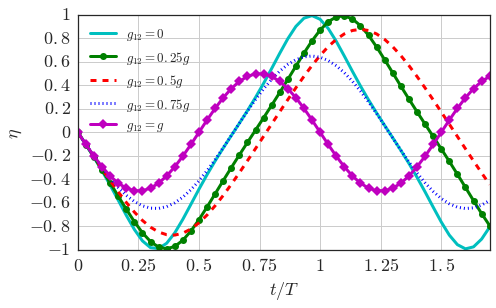

In [24]:
def frac(fraction):
    if fraction == 0.:
        return '0$'
    elif fraction == .25:
        return '0.25 g$'
    elif fraction == .5:
        return '0.5 g$'
    elif fraction == .75:
        return '0.75 g$'
    elif fraction == 1.:
        return 'g$'
    else:
        return '$'

def linestyle(fraction):
    if fraction == 0.:
        return 'c-'
    elif fraction == .25:
        return 'g-o'
    elif fraction == .5:
        return 'r--'
    elif fraction == .75:
        return 'b:'
    elif fraction == 1.:
        return 'm-D'
    else:
        return '$'
time_axis = np.linspace(0, 1.7, 103)
plt.figure(figsize=figsize)
for indx in range(len(gAB_over_g_serie)):
    plt.plot(time_axis[::2], np.array(list2_N2[indx][::2])-np.array(list2_N1[indx][::2]),
             linestyle(gAB_over_g_serie[indx]), label='$g_{12} =' + frac(gAB_over_g_serie[indx]))


plt.xlabel('$t/T$', fontsize=fontsize)
plt.ylabel('$\eta$', fontsize=fontsize)
plt.xticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5], ['$0$', '$0.25$', '$0.5$', '$0.75$', '$1$', '$1.25$', '$1.5$'],
           fontsize=fontsize)
plt.yticks([-1, -.8, -.6, -.4, -.2, 0., 0.2, 0.4, 0.6, 0.8, 1], 
           ['$-1$', '$-0.8$', '$-0.6$', '$-0.4$', '$-0.2$', '$0$', '$0.2$', '$0.4$', '$0.6$', '$0.8$', '$1$'],
           fontsize=fontsize)
plt.xlim(0, 1.7)
plt.grid()
plt.legend(fontsize=fontsize-5, loc=0, fancybox=True)
plt.tight_layout()
plt.show()

We now switch on the harmonic trap and study whether Eqs. (62) provides a good approximation to the dynamics of the population transfer. The simulation takes slightly over a minute to complete.

In [25]:
# linear size of the lattice
dim = 100
periodicBoundary = False
vortex = False
harmonicPot = True

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1.

# start evolution
Rabi_period = np.pi
coupling = 20
phase_diff = np.pi/3.
gAB_over_g = 1.
time0 = time.time()
N1, N2, phase1, phase2 = density_oscillation(dim, periodicBoundary, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                                             gAB_over_g, vortex, harmonicPot, phase_diff)

eta = np.array(N2) - np.array(N1)
phi = np.array(phase2) - np.array(phase1)
print("Total time:", time.time()-time0) 

Total time: 65.89082336425781


Given $\eta$ and $S$, Eqs. (62) are computed:

In [26]:
TF_radius = (4*coupling/np.pi)**0.25
length = np.array([6, np.ceil(4*TF_radius)]).max() + 4.  # physical length of the lattice
def d_eta_dt(eta, phi):
    return 2*np.pi/Rabi_period * np.sqrt(1. - eta**2) * np.sin(phi)
def d_phi_dt(eta, phi):
    return -coupling*(1.-gAB_over_g)*eta/(length*length) - 2*np.pi/Rabi_period * eta / np.sqrt(1. - eta**2) * np.cos(phi)

_d_eta_dt = d_eta_dt(eta, phi)
_d_phi_dt = d_phi_dt(eta, phi)

d_eta_dt = (np.roll(eta[0:60], -1) - np.roll(eta[0:60], 1)) / (2.* Rabi_period/60)
d_eta_dt = np.insert(d_eta_dt, len(d_eta_dt), d_eta_dt[0])
phi_diff = np.roll(phi, -1) - np.roll(phi, 1)
for i in range(len(phi_diff)):
    if np.absolute(phi_diff[i]) > np.pi:
        phi_diff[i] -= np.sign(phi_diff[i]) * 2*np.pi 
d_phi_dt = phi_diff / (2.* Rabi_period/60)

The left-hand and right-hand sides of Eqs. (62) are compared, generating Fig. 9 of the paper:

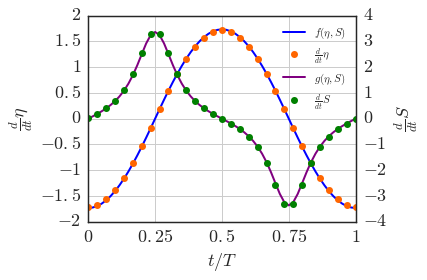

In [27]:
time_axis = np.linspace(0, 1., 61)
plt.figure(figsize=figsize)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(time_axis, _d_eta_dt, 'b', lw=lw, label='$f(\eta, S)$')
lns2 = ax1.plot(time_axis[::2], d_eta_dt[::2], 'o', c='#FF6600', label=r'$\frac{d}{dt} \eta$')
lns3 = ax2.plot(time_axis, _d_phi_dt, c='#800080', lw=lw, label='$g(\eta, S)$')
lns4 = ax2.plot(time_axis[::2], d_phi_dt[::2], 'go', label=r'$\frac{d}{dt} S$')

ax1.set_xlabel('$t/T$', fontsize=fontsize)
ax1.set_ylabel(r'$\frac{d}{dt} \eta$', fontsize=fontsize)
ax2.set_ylabel(r'$\frac{d}{dt} S$', fontsize=fontsize)

# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, fontsize=fontsize-7, fancybox=True)

ax1.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_xticklabels(['$0$', '$0.25$', '$0.5$', '$0.75$', '$1$'], fontsize=fontsize)
ax1.set_yticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
ax1.set_yticklabels(['$-2$', '$-1.5$', '$-1$', '$-0.5$', '$0$', '$0.5$', '$1$', '$1.5$', '$2$'], fontsize=fontsize)
ax2.set_yticks([-4, -3, -2, -1, 0, 1, 2, 3, 4])
ax2.set_yticklabels(['$-4$', '$-3$', '$-2$', '$-1$', '$0$', '$1$', '$2$', '$3$', '$4$'], fontsize=fontsize)

ax1.grid()
plt.tight_layout()
plt.show()

Finally we include the vortex imprinting, comparing it against the uniform phase scenario. It finishes in about four minutes:

In [28]:
# linear size of the lattice
dim = 100
periodicBoundary = True
vortex = False
harmonicPot = False

# number of Rabi periods to be simulated
Rabi_periods_to_be_simulated = 1

# start evolution
gAB_over_g =1.
Rabi_period = np.pi
coupling = 20.

list3_N1 = []
list3_N2 = []
phase_diff_serie = np.array([1/2., 0.])*np.pi
time0 = time.time()
for phase_diff in phase_diff_serie:
    N1, N2, phase1, phase2 = density_oscillation(dim, periodicBoundary, Rabi_period, coupling,
                                                 Rabi_periods_to_be_simulated, gAB_over_g, vortex, harmonicPot,
                                                 phase_diff)
    list3_N1.append(N1)
    list3_N2.append(N2)

periodicBoundary = False
vortex = True
harmonicPot = True
N1, N2, phase1, phase2 = density_oscillation(dim, periodicBoundary, Rabi_period, coupling, Rabi_periods_to_be_simulated, 
                                             gAB_over_g, vortex, harmonicPot, phase_diff)
list3_N1.append(N1)
list3_N2.append(N2)
print("Total time:", time.time()-time0) 

Total time: 250.72946310043335


The following code plots the results, generating Fig. 10 of the paper:

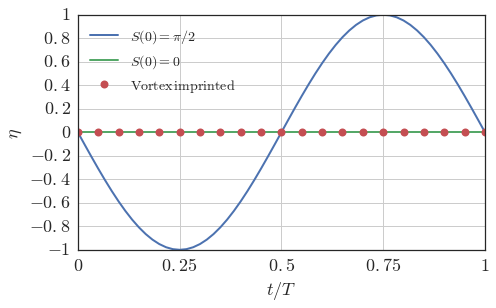

In [29]:
phase_diff_serie = np.array([1/2., 0.])*np.pi
time_axis = np.linspace(0, 1., 61)
plt.figure(figsize=figsize)

plt.plot(time_axis, np.array(list3_N2[0])-np.array(list3_N1[0]), label='$S(0) = \pi/2$', lw=lw)
plt.plot(time_axis, np.array(list3_N2[1]) - np.array(list3_N1[1]), label='$S(0) = 0$', lw=lw)
plt.plot(time_axis[::3], np.array(list3_N2[len(phase_diff_serie)][::3])-np.array(list3_N1[len(phase_diff_serie)][::3]),
         'o', ms=8, label=r'$\mathrm{Vortex \, imprinted}$')

plt.xlabel('$t/T$', fontsize=fontsize)
plt.ylabel('$\eta$', fontsize=fontsize)
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['$0$', '$0.25$', '$0.5$', '$0.75$', '$1$'], fontsize=fontsize)
plt.yticks([-1, -.8, -.6, -.4, -.2, 0., 0.2, 0.4, 0.6, 0.8, 1], 
           ['$-1$', '$-0.8$', '$-0.6$', '$-0.4$', '$-0.2$', '$0$', '$0.2$', '$0.4$', '$0.6$', '$0.8$', '$1$'], 
           fontsize=fontsize)
plt.ylim(-1, 1)
plt.grid()
plt.legend(fontsize=fontsize-4, loc=2, fancybox=True)
plt.tight_layout()
plt.show()